# MLFlow runs

In [1]:
import mlflow
import seaborn as sns

mlflow.tracking.set_tracking_uri('../mlruns')

labels_methods = {
    'cam': 'CAM', 'gradcam': 'Grad-CAM', 'gradcam++': 'Grad-CAM++', 'scorecam': 'Score-CAM', 'minmaxcam': 'MinMaxCAM'}

## Functions

In [2]:
from mlflow import MlflowClient

def mlflow_create_filter(conditions=None):
    if conditions is None:
        return ''
    keys = conditions.keys()
    values = [ f'"{v}"' if type(v) == str else v for v in conditions.values()]
    filter = ' AND '.join([f'{k} = {v}' for k,v in zip(keys, values)])
    return filter

def mlflow_get_runs(experiment_name, conditions=None):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    filter = mlflow_create_filter(conditions)
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter)
    return runs

def get_runs(experiment_name, filter=''):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter)
    return runs

def get_best_run(runs, best_metrics):
    if runs is None or runs.shape[0] == 0:
        return None
    for metric in best_metrics:
        runs = runs.loc[runs[f'metrics.{metric}'] >= runs[f'metrics.{metric}'].max()]
    # pick first in the list
    run = runs.loc[runs.index[0]]
    return run


def epoch_values(x, metric):
    run_id = x.run_id
    client = MlflowClient()
    values = [[m.value for m in client.get_metric_history(id, metric)] for id in run_id]
    steps = [list(range(len(v))) for v in values]
    return steps, values

def epoch_steps(x):
    steps, _ = epoch_values(x, 'val_accuracy')
    return steps


def epoch_accuracy(x):
    _, values = epoch_values(x, 'val_accuracy')
    return values


def epoch_maxboxaccv3(x):
    _, values = epoch_values(x, 'val_MaxBoxAccV3')
    return values

In [3]:
import matplotlib.pyplot as plt
import os, json
import numpy as np

def get_mlflow_boxacc_prcurve(experiment_name = 'wsol2', conditions=None, split='test', box_metric='MaxBoxAccV3', mask_metric=None):
    boxacc = {}
    prcurve = {}
    iou_thresholds = [30, 50, 70]
    runs = mlflow_get_runs(experiment_name, conditions)
    for row in runs.itertuples(index=False):
        artifact_uri = row.artifact_uri
        artifact_path = artifact_uri[len('file://'):]
        config_path = os.path.join(artifact_path, 'state/config.json')
        with open(config_path) as fp:
            _config = json.load(fp)
        boxacc[_config['wsol_method']] = {}
        for iou_threshold in iou_thresholds:
            boxacc_path = os.path.join(artifact_path, f'data/{split}/{box_metric}_box_acc_iou_{iou_threshold}.json')
            with open(boxacc_path) as fp:
                _boxacc = json.load(fp)
                values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
                boxacc[_config['wsol_method']][iou_threshold] = values
        if mask_metric is not None:
            prcurve_path = os.path.join(artifact_path, f'data/{split}/pr_curve.json')
            with open(prcurve_path) as fp:
                # _prcurve = json.load(fp)
                # values = {k: _prcurve[k] for k in ['precision', 'recall']}
                prcurve[_config['wsol_method']] = json.load(fp)
        else:
            prcurve = None
    return boxacc, prcurve

def plot_boxacc(boxacc, title, iou_thresholds=None):
    # plot lines
    if iou_thresholds is None:
        iou_thresholds = [30, 50, 70]
    for method, iou_values in boxacc.items():
        for iou_threshold, values in iou_values.items():
            if iou_threshold not in iou_thresholds:
                continue
            x = np.asarray(values['cam_threshold'])
            y = np.asarray(values['box_accuracy'])
            xmax = x[np.argmax(y)]
            ymax = y.max()
            text = f"({xmax:.2f}, {ymax:.2f})"
            lb_method = labels_methods[method]
            label = lb_method if len(iou_thresholds) == 1 else f'{lb_method} {iou_threshold}'
            label = f'{label} {text}'
            plt.plot(x, y, label=label)
            plt.plot(xmax, ymax, 'ro')
            # plt.text(xmax + 0.01, ymax + 0.01, text)
    plt.xlabel("Score map threshold")
    plt.ylabel("BoxAcc")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prcurve(curve, title):
    # plot lines
    for method, values in curve.items():
        label = f"{method} (auc {values['auc']:.2f})"
        plt.plot(values['recall'], values['precision'], label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

In [54]:
import pandas as pd

def mlflow_runs_to_latex(experiment_name, conditions=None, split='test', metrics=None, label='', caption=''):
    if conditions is not None and 'tags.dataset' in conditions and conditions['tags.dataset'] == 'SYNTHETIC':
        dataset = 'SYNTHETIC'
    else:
        dataset = 'ILSVRC'
    if metrics is None:
        metrics = ['MaxBoxAcc', 'MaxBoxAccV2', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_recall']
        if dataset == 'SYNTHETIC':
            metrics.append('PxAP')
    runs = mlflow_get_runs(experiment_name, conditions=conditions)
    if experiment_name == 'mwsol_resnet50_imagenet':
        runs = runs.loc[runs.start_time > '2023-05-01']
    cols_metrics = [f'metrics.{split}_{metric}' for metric in metrics]
    cols = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec'] + cols_metrics
    cols_renamed = [c.split('.')[-1] for c in cols]
    mapper = dict(zip(cols, cols_renamed))
    df = runs.loc[:, cols].rename(columns=mapper)
    mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
    df = df.loc[:, df.columns].rename(columns=mapper)
    # df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
    # pd.set_option("display.precision", 2)
    for metric in metrics:
        df[metric] *= 100 # to percentage
    df = df.replace({'method': labels_methods})
    if dataset == 'SYNTHETIC':
        specs = df['dataset_spec'].unique()
        cols_pivot = ['dataset_spec']
        df = df.pivot(index='method', columns=cols_pivot, values=metrics)
        cols = metrics
        df = df.loc[:, cols]
        df = df.sort_index()
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                              label=label, caption=caption, position="ht")

        cols_format = dict([((m, spec), '{:.2f}') for m in metrics for spec in specs])
        s = df.style
        s = s.format(cols_format)
        # s = s.highlight_max(subset=metrics, axis=0, props='bfseries: ;')
        s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
        s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')

        latex_table2 = s.to_latex(
                column_format="lrrrrrrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
    else:
        cols = ['method'] + metrics
        df = df.loc[:, cols]
        # remove minmaxcam from dataset for Imagenet VGG16-GAP (could not be trained enough)
        if 'tags.architecture' in conditions and conditions['tags.architecture'] == 'vgg16':
            if 'tags.architecture_type' in conditions and conditions['tags.architecture_type'] == 'cam':
                df = df.loc[df['method'] != 'MinMaxCAM']
        df = df.sort_values('method')
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                      label=label, caption=caption, position="ht", index=False)

        cols_format = dict([(m, '{:.2f}') for m in metrics])
        s = df.set_index('method').style
        s = s.format(cols_format)
        s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
        s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')

        latex_table2 = s.to_latex(
                column_format="lrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
    print(latex_table)
    print(latex_table2)

## VGG16-GAP

In [5]:
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols = ['tags.method', 'tags.dataset', 'tags.dataset_spec', 'tags.architecture', 'tags.architecture_type', 'artifact_uri']
df = df.loc[:, cols]
cols_renamed = [c.split('.')[-1] for c in cols]
df = df.rename(columns=dict(zip(cols,cols_renamed)))
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

### MaxBoxAccV3 and PxAP

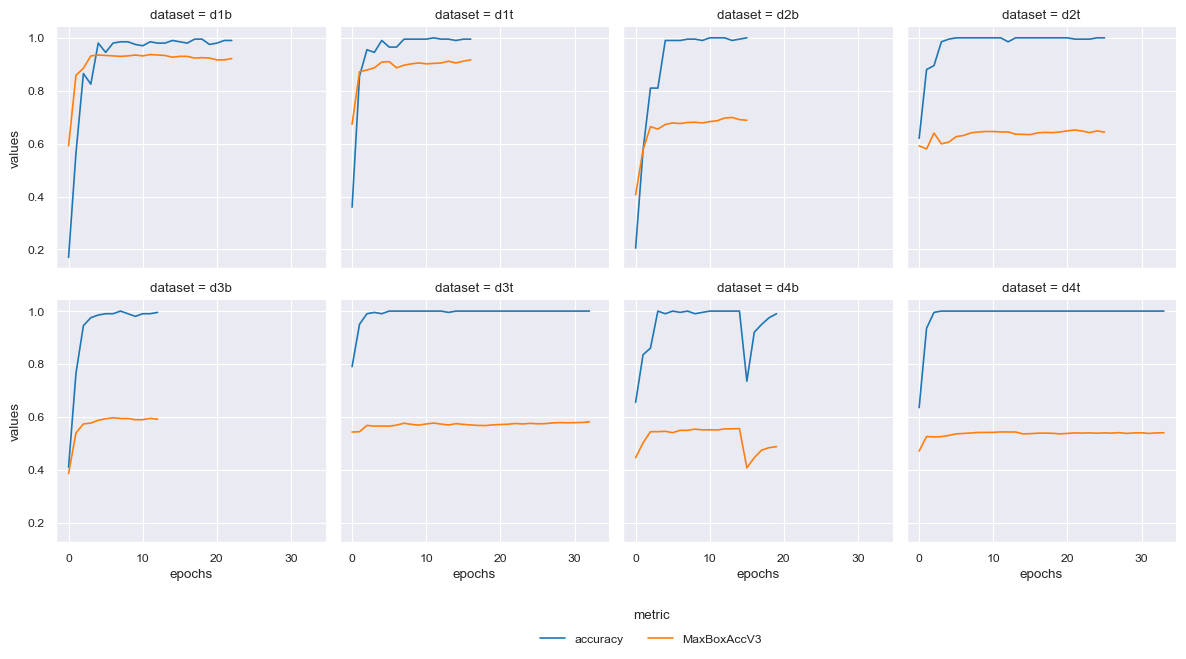

In [77]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}

df = mlflow_get_runs(experiment_name, conditions)
# df_trained = df.loc[df['tags.train']=='True']
# run_ids = df_trained['run_id']
# artifact_uris = df_trained['artifact_uri']
# run_names = df_trained['tags.mlflow.runName']
# run_id = run_ids
# artifact_uri = artifact_uris
# # run = mlflow.get_run(run_id)
# for run_id, run_name, artifact_uri in zip(run_ids, run_names, artifact_uris):
#     training_json = mlflow.artifacts.load_dict(artifact_uri[5:] + "/state/training.json")
#     print(f'{run_name}: {training_json["epochs_trained"]}/{training_json["epochs_planned"]} epochs')

cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
# df = df.loc[(df['method']=='cam') | (df['method']=='minmaxcam')&(df['start_time']>'2023-03-01')]
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')
data = data.loc[df['method']=='cam']

sns.set_style("darkgrid")
# sns.set_context("paper")
hue_order = ['accuracy','MaxBoxAccV3']
# sns_plot = sns.relplot(data, x="epochs", y="values", hue="metric", col="dataset", col_wrap=4, kind="line")
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
g.savefig(f'fig_loc_vs_acc_vgg16_gap_cam_synthetic.png')

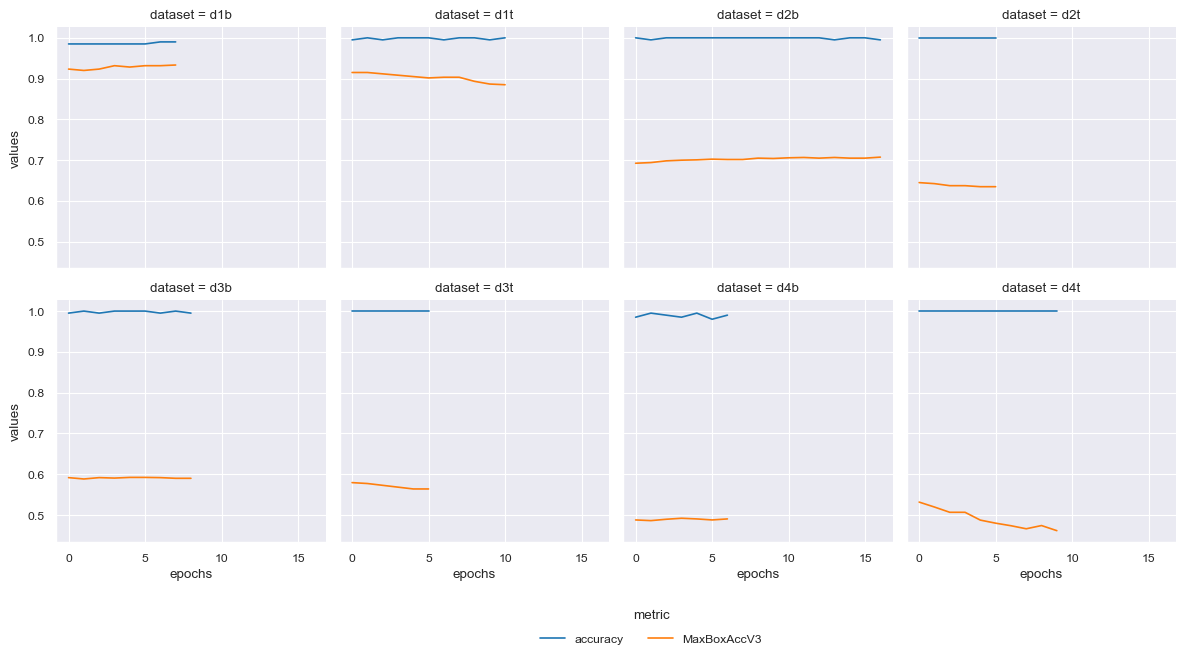

In [78]:
data = df.sort_values('dataset')
data = data.loc[df['method']=='minmaxcam']

sns.set_style("darkgrid")
# sns.set_context("paper")
hue_order = ['accuracy','MaxBoxAccV3']
# sns_plot = sns.relplot(data, x="epochs", y="values", hue="metric", col="dataset", col_wrap=4, kind="line")
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
g.savefig(f'fig_loc_vs_acc_vgg16_gap_minmaxcam_synthetic.png')

In [54]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
# conditions |= {
#     'tags.dataset_spec': 'd4b'
# }
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3 for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 93.67 & 91.67 & 66.58 & 65.67 & 60.94 & 59.11 & 48.67 & 54.87 \\
Grad-CAM++ & 94.17 & 92.50 & 67.33 & 65.08 & 62.50 & 59.11 & 48.42 & 55.17 \\
MinMaxCAM & 94.83 & 89.33 & 67.33 & 65.17 & 62.83 & 57.67 & 48.87 & 43.33 \\
Score-CAM & 94.17 & 88.83 & 73.00 & 68.08 & 69.33 & 65.11 & 51.37 & 56.58 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3 for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 93.67 & 91.67 & \color{purple} \bfseries 66.58 & 65.67 & \co

In [55]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
# conditions |= {
#     'tags.dataset_spec': 'd4b'
# }
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 88.57 & 84.86 & 73.39 & 71.86 & 69.34 & 65.39 & 63.22 & 63.96 \\
Grad-CAM++ & 88.82 & 86.57 & 72.96 & 71.42 & 69.63 & 64.82 & 62.94 & 63.56 \\
MinMaxCAM & 89.09 & 83.47 & 73.50 & 72.66 & 71.91 & 63.68 & 63.46 & 52.37 \\
Score-CAM & 87.51 & 78.66 & 76.77 & 71.35 & 74.79 & 69.70 & 64.36 & 63.96 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 88.57 & 84.86 & 73.39 & 7

In [56]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
# conditions |= {
#     'tags.dataset_spec': 'd4b'
# }
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for VGG16-GAP on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 80.82 & 80.45 & 78.52 & 74.68 & 76.31 & 72.79 & 65.69 & 72.55 \\
Grad-CAM++ & 81.82 & 81.56 & 79.33 & 74.96 & 77.90 & 73.20 & 66.92 & 73.21 \\
MinMaxCAM & 81.29 & 80.46 & 78.62 & 74.00 & 75.44 & 71.43 & 66.10 & 57.24 \\
Score-CAM & 80.71 & 81.07 & 77.96 & 74.32 & 77.64 & 75.10 & 67.34 & 73.45 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for VGG16-GAP on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 80.82 & \color{purple} \bfseries 80.45 & 78.52 & 74.68 & 76.31 & 72.79 & \color{purple} \bfseries 65.69 & 72.55 \\
Grad-CAM++ &

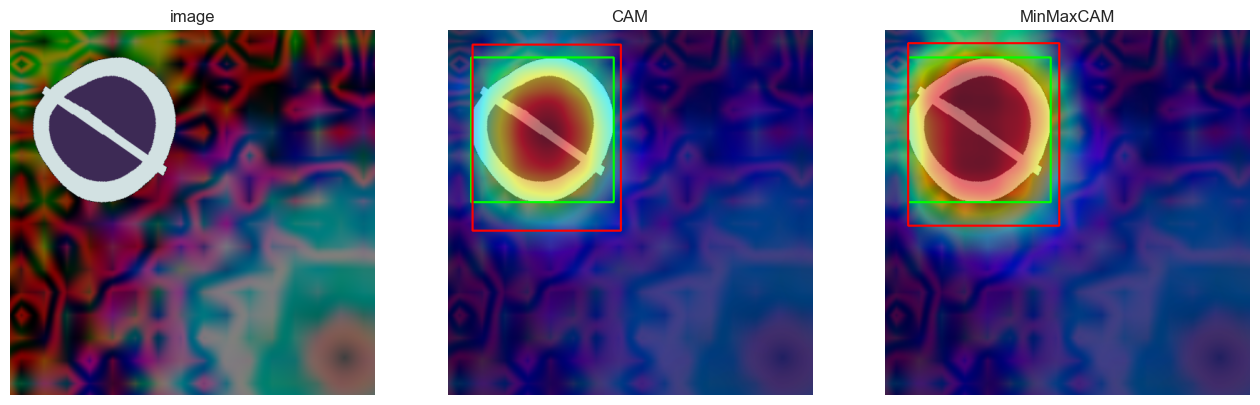

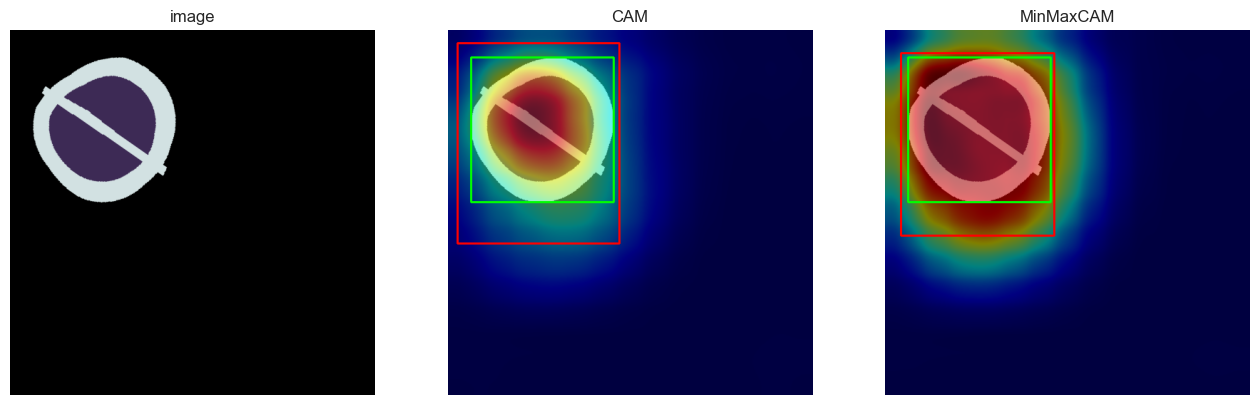

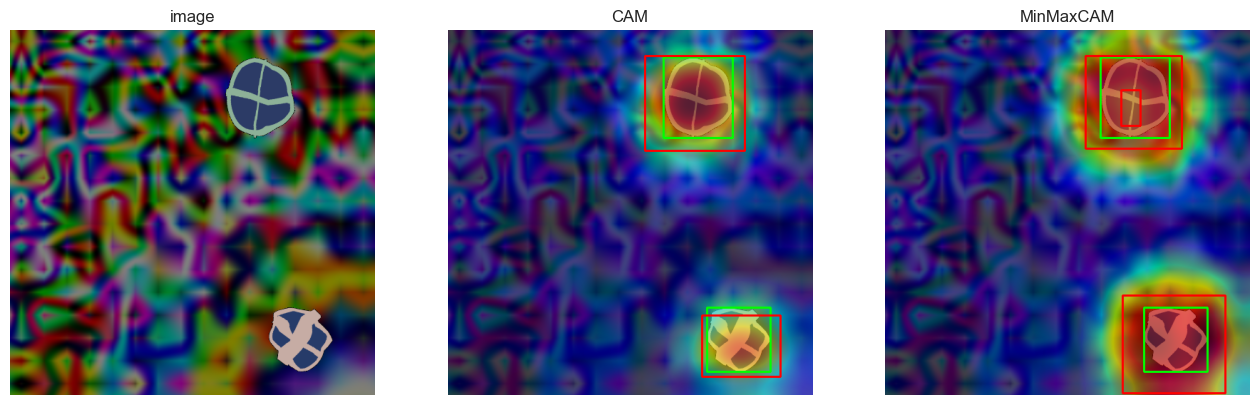

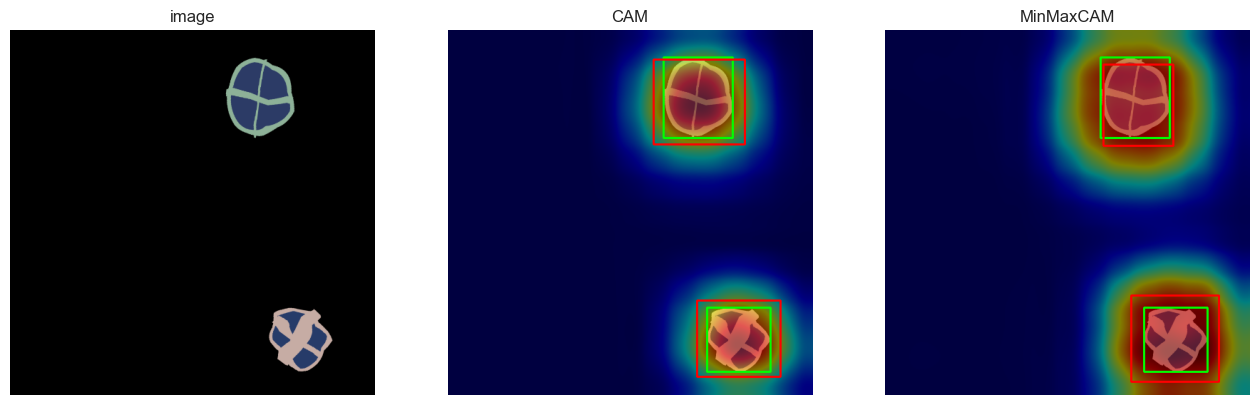

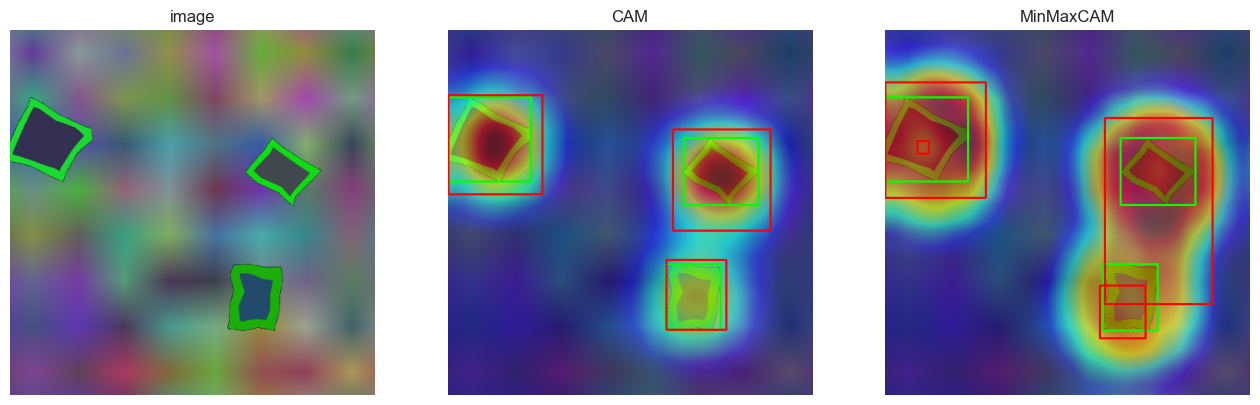

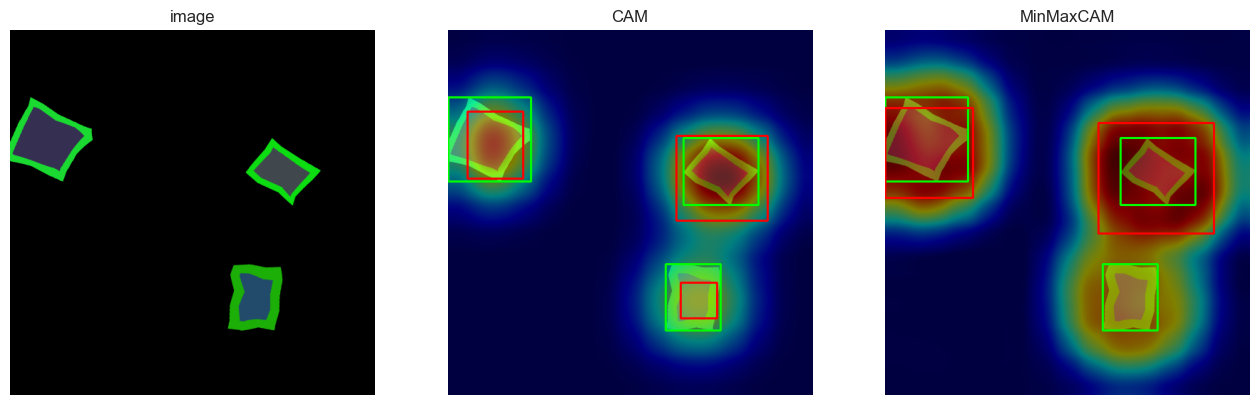

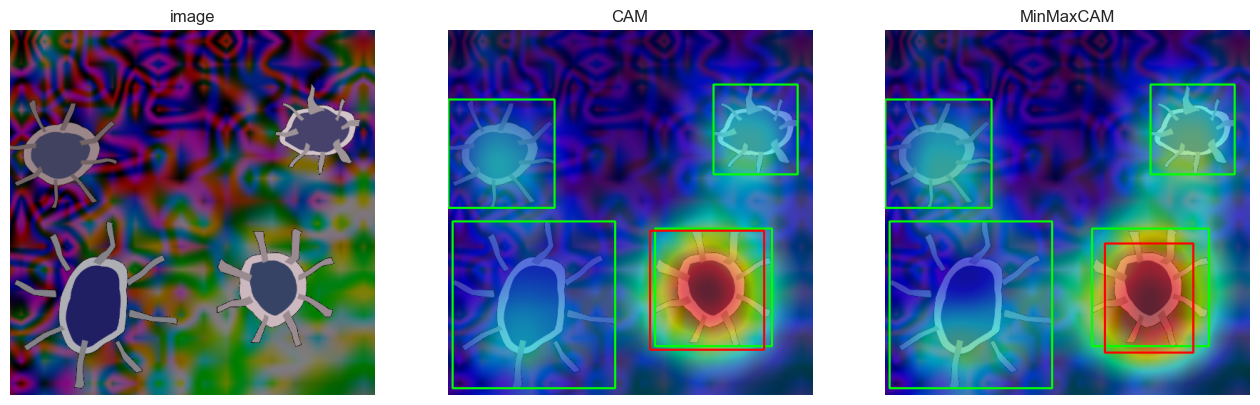

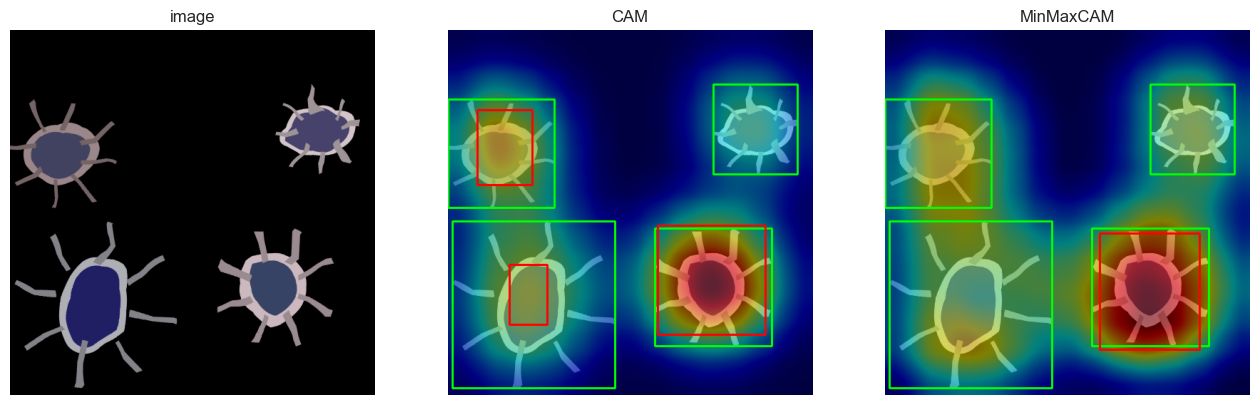

In [44]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

split = 'test'
image_id = 10

arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol2_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

for spec in sorted(df['tags.dataset_spec'].unique()):
    df_spec = df.loc[df['tags.dataset_spec'] == spec]
    df_spec = df_spec.loc[:, ['tags.method', 'tags.dataset_spec', 'artifact_uri']]
    df_spec = df_spec.sort_values('tags.method')
    spec_dict = df_spec.set_index('tags.method').to_dict()
    uris = spec_dict['artifact_uri']
    spec = '_'.join(list(spec))
    filebase = f'SYNTHETIC_{spec}_test_{image_id}'
    file_img = filebase + '_img_0.png'
    file_ann = filebase + '_ann_0.png'
    file_cam = filebase + '_cam_0.png'
    file_seg = filebase + '_seg_0.png'
    path_img_orig = os.path.join(f'/Users/goemaereg/github.com/thesis/data/dataset/SYNTHETIC/{spec}/{split}/SYNTHETIC_{spec}_{split}_{image_id}.png')
    _, axes = plt.subplots(1, len(spec_dict) + 1, figsize=(16, 8))
    img = read_image(path=path_img_orig)
    axes[0].imshow(to_pil_image(img))
    axes[0].axis('off')
    axes[0].set_title('image')
    for i, (method, uri) in enumerate(uris.items()):
        path_img = os.path.join(uri, 'xai', split, file_ann)
        img = read_image(path=path_img)
        axes[i+1].imshow(to_pil_image(img))
        axes[i+1].axis('off')
        axes[i+1].set_title(labels_methods[method])
    plt.show()

### Localization performance at varying CAM thresholds

In [26]:
path_basedir = '../train_log'
methods = ['cam', 'gradcam++', 'scorecam', 'minmaxcam']
background_filter = 'b'

In [27]:
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
runs = mlflow_get_runs(experiment_name, conditions=conditions)
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [28]:
runs

run_id       experiment_id    status   
0   25efa11783df4218a9d57bd166cea872  998329977809601835  FINISHED  \
2   c844b03070df4759b7cef556bea5f396  998329977809601835  FINISHED   
4   f9bc1986e4bb4f57b6c9741fb695d114  998329977809601835  FINISHED   
6   0ed45a04bcd249cf818faac31bcfb3df  998329977809601835  FINISHED   
8   4a5f8a55182a4265a6568624a5bc1630  998329977809601835  FINISHED   
10  4536131124ac45418896364fbcbc0814  998329977809601835  FINISHED   
12  eac8230f6acc413eb85da3e3149305d3  998329977809601835  FINISHED   
14  c0698ce23454462291227590edbde23f  998329977809601835  FINISHED   
16  1f744062b33d42b68bb8640e5ddb6f27  998329977809601835  FINISHED   
18  d87c933d60bb4ce7b40abd0b0a230566  998329977809601835  FINISHED   
20  367c6d159fde4218ae099dfd80d020a5  998329977809601835  FINISHED   
22  5b11831472dd4c80b8c95b52e07fc7b1  998329977809601835  FINISHED   
24  3e707bcb55a446b99d33ff7afcfa12ec  998329977809601835  FINISHED   
26  f96710fc1ec54ab0b0d5a9a4cbca1ad3  998329977809601835  FINISHED   
28  46ad4d2bf900458ab4c3318d4b9b6701  998329977809601835  FINISHED   
30  1c4a6b5954954f51907e068c0021f7b2  998329977809601835  FINISHED   

                                         artifact_uri   
0   file:///Users/goemaereg/github.com/thesis/mlru...  \
2   file:///Users/goemaereg/github.com/thesis/mlru...   
4   file:///Users/goemaereg/github.com/thesis/mlru...   
6   file:///Users/goemaereg/github.com/thesis/mlru...   
8   file:///Users/goemaereg/github.com/thesis/mlru...   
10  file:///Users/goemaereg/github.com/thesis/mlru...   
12  file:///Users/goemaereg/github.com/thesis/mlru...   
14  file:///Users/goemaereg/github.com/thesis/mlru...   
16  file:///Users/goemaereg/github.com/thesis/mlru...   
18  file:///Users/goemaereg/github.com/thesis/mlru...   
20  file:///Users/goemaereg/github.com/thesis/mlru...   
22  file:///Users/goemaereg/github.com/thesis/mlru...   
24  file:///Users/goemaereg/github.com/thesis/mlru...   
26  file:///Users/goemaereg/github.com/thesis/mlru...   
28  file:///Users/goemaereg/github.com/thesis/mlru...   
30  file:///Users/goemaereg/github.com/thesis/mlru...   

                         start_time                         end_time   
0  2023-04-04 18:02:18.438000+00:00 2023-04-04 18:07:34.874000+00:00  \
2  2023-04-04 16:21:55.409000+00:00 2023-04-04 16:28:22.927000+00:00   
4  2023-04-04 14:27:10.311000+00:00 2023-04-04 14:37:50.396000+00:00   
6  2023-04-04 12:42:06.321000+00:00 2023-04-04 12:47:32.161000+00:00   
8  2023-04-02 15:01:00.532000+00:00 2023-04-02 15:22:33.433000+00:00   
10 2023-04-02 14:10:22.695000+00:00 2023-04-02 14:32:04.952000+00:00   
12 2023-04-02 13:18:18.054000+00:00 2023-04-02 13:39:29.086000+00:00   
14 2023-04-02 12:55:56.120000+00:00 2023-04-02 13:17:32.581000+00:00   
16 2023-04-02 12:23:56.424000+00:00 2023-04-02 12:25:03.838000+00:00   
18 2023-04-02 12:22:59.001000+00:00 2023-04-02 12:24:06.544000+00:00   
20 2023-04-02 12:22:06.224000+00:00 2023-04-02 12:23:08.107000+00:00   
22 2023-04-02 12:21:15.040000+00:00 2023-04-02 12:22:37.491000+00:00   
24 2023-04-02 06:19:32.959000+00:00 2023-04-02 06:31:31.646000+00:00   
26 2023-04-02 05:52:43.786000+00:00 2023-04-02 06:00:57.129000+00:00   
28 2023-04-02 05:20:29.836000+00:00 2023-04-02 05:30:20.511000+00:00   
30 2023-04-01 19:29:25.002000+00:00 2023-04-01 19:42:46.095000+00:00   

    metrics.val_MaxBoxAccV2_precision  metrics.test_MaxBoxAccV2_recall_IOU_50   
0                            0.287704                                   0.970  \
2                            0.369217                                   0.990   
4                            0.504633                                   0.955   
6                            0.894930                                   0.980   
8                            0.289453                                   0.960   
10                           0.328544                                   0.990   
12                           0.468143                                   0.950

In [29]:
runs.loc[:, ['tags.method', 'tags.architecture', 'tags.dataset', 'tags.dataset_spec', 'artifact_uri']]

tags.method tags.architecture tags.dataset tags.dataset_spec   
0    minmaxcam             vgg16    SYNTHETIC               d4b  \
2    minmaxcam             vgg16    SYNTHETIC               d3b   
4    minmaxcam             vgg16    SYNTHETIC               d2b   
6    minmaxcam             vgg16    SYNTHETIC               d1b   
8     scorecam             vgg16    SYNTHETIC               d4b   
10    scorecam             vgg16    SYNTHETIC               d3b   
12    scorecam             vgg16    SYNTHETIC               d2b   
14    scorecam             vgg16    SYNTHETIC               d1b   
16   gradcam++             vgg16    SYNTHETIC               d4b   
18   gradcam++             vgg16    SYNTHETIC               d3b   
20   gradcam++             vgg16    SYNTHETIC               d2b   
22   gradcam++             vgg16    SYNTHETIC               d1b   
24         cam             vgg16    SYNTHETIC               d4b   
26         cam             vgg16    SYNTHETIC               d3b   
28         cam             vgg16    SYNTHETIC               d2b   
30         cam             vgg16    SYNTHETIC               d1b   

                                         artifact_uri  
0   file:///Users/goemaereg/github.com/thesis/mlru...  
2   file:///Users/goemaereg/github.com/thesis/mlru...  
4   file:///Users/goemaereg/github.com/thesis/mlru...  
6   file:///Users/goemaereg/github.com/thesis/mlru...  
8   file:///Users/goemaereg/github.com/thesis/mlru...  
10  file:///Users/goemaereg/github.com/thesis/mlru...  
12  file:///Users/goemaereg/github.com/thesis/mlru...  
14  file:///Users/goemaereg/github.com/thesis/mlru...  
16  file:///Users/goemaereg/github.com/thesis/mlru...  
18  file:///Users/goemaereg/github.com/thesis/mlru...  
20  file:///Users/goemaereg/github.com/thesis/mlru...  
22  file:///Users/goemaereg/github.com/thesis/mlru...  
24  file:///Users/goemaereg/github.com/thesis/mlru...  
26  file:///Users/goemaereg/github.com/thesis/mlru...  
28  file:///Users/goemaereg/github.com/thesis/mlru...  
30  file:///Users/goemaereg/github.com/thesis/mlru...

## VGG16 vanilla

In [87]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3 for VGG16 on synthetic}
\label{tb:maxboxaccv3_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 82.83 & 77.33 & 56.08 & 37.33 & 55.17 & 44.39 & 48.79 & 40.21 \\
Grad-CAM++ & 77.00 & 70.83 & 40.92 & 26.83 & 47.39 & 37.33 & 40.17 & 34.08 \\
Score-CAM & 81.83 & 74.50 & 55.00 & 44.58 & 54.44 & 48.56 & 51.04 & 45.79 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3 for VGG16 on synthetic}
\label{tb:maxboxaccv3_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & \color{teal} \bfseries 82.83 & \color{teal} \bfseries 77.33 & \color{teal} \bfseries 56.08 & 37.33 & \color{teal} \bfseries 55.17 & 44.39 & 48.79 & 40.21 \\
Gra

In [80]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for VGG16 on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 60.23 & 47.89 & 57.65 & 39.36 & 57.08 & 42.90 & 51.59 & 46.86 \\
Grad-CAM++ & 34.13 & 31.95 & 36.21 & 21.59 & 43.89 & 29.09 & 36.42 & 30.13 \\
Score-CAM & 66.28 & 57.89 & 55.51 & 47.12 & 57.25 & 50.51 & 55.35 & 52.23 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for VGG16 on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & 60.23 & 47.89 & \color{teal} \bfseries 57.65 & 39.36 & 57.08 & 42.90 & 51.59 & 46.86 \\
Grad-CAM++ &

In [82]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for VGG16 on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 71.14 & 65.89 & 60.66 & 42.86 & 61.69 & 46.63 & 56.26 & 50.54 \\
Grad-CAM++ & 66.88 & 59.54 & 49.45 & 29.74 & 56.42 & 40.43 & 50.40 & 39.47 \\
Score-CAM & 69.19 & 65.12 & 61.79 & 50.66 & 62.64 & 56.56 & 58.82 & 56.15 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for VGG16 on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & \color{teal} \bfseries 71.14 & \color{teal} \bfseries 65.89 & 60.66 & 42.86 & 61.69 & 46.63 & 56.26 & 50.54 \\
Grad-CAM++ & \color{purple} \bfseries 66.88 & \color{purple} \bfseries 59.54 & \color{purpl

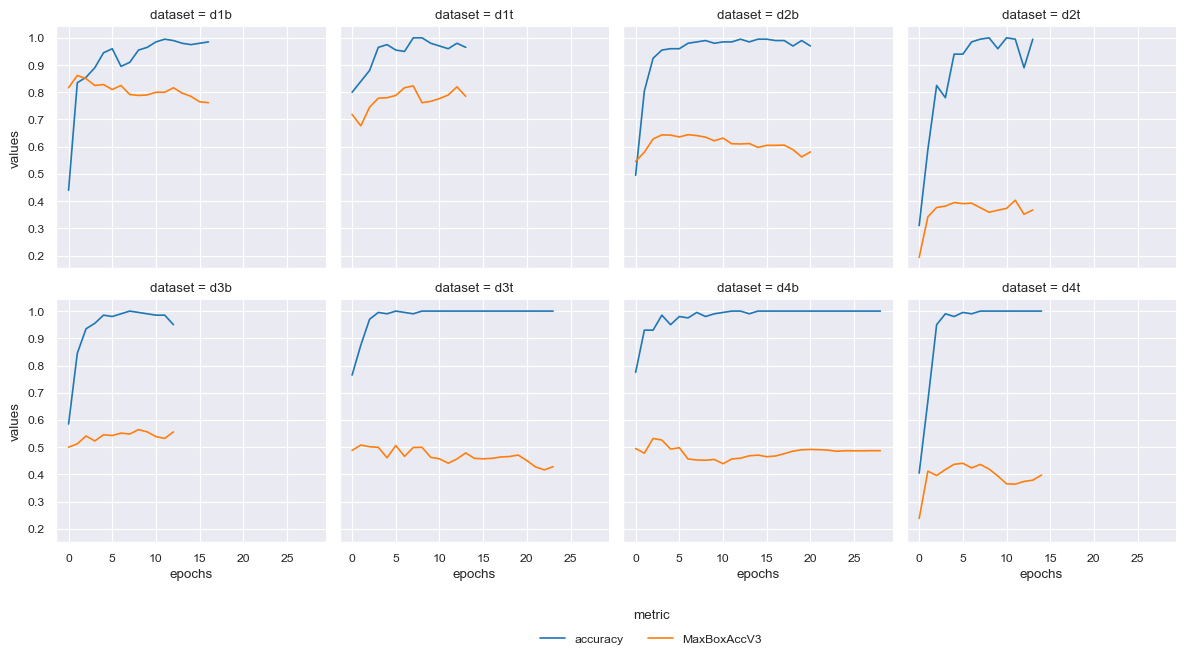

In [91]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}

df = mlflow_get_runs(experiment_name, conditions)

cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')
data = data.loc[df['method']=='gradcam']

sns.set_style("darkgrid")
# sns.set_context("paper")
hue_order = ['accuracy','MaxBoxAccV3']
# sns_plot = sns.relplot(data, x="epochs", y="values", hue="metric", col="dataset", col_wrap=4, kind="line")
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
# g.savefig(f'fig_loc_vs_acc_vgg16_base_cam_synthetic.png')

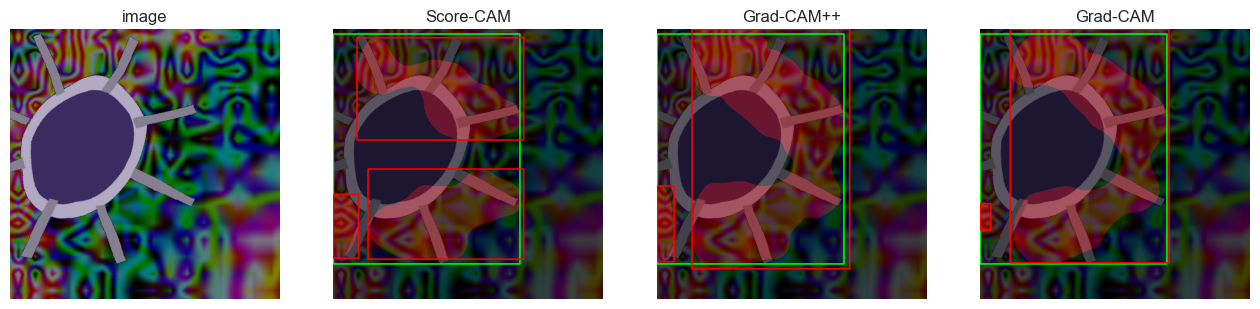

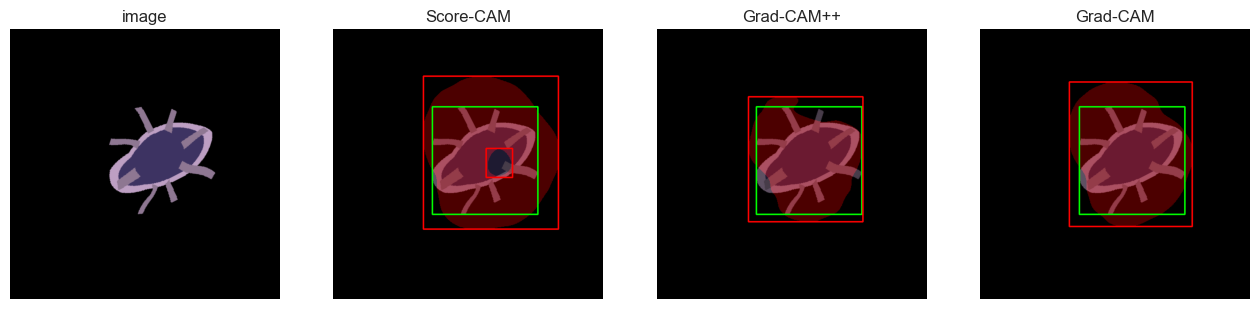

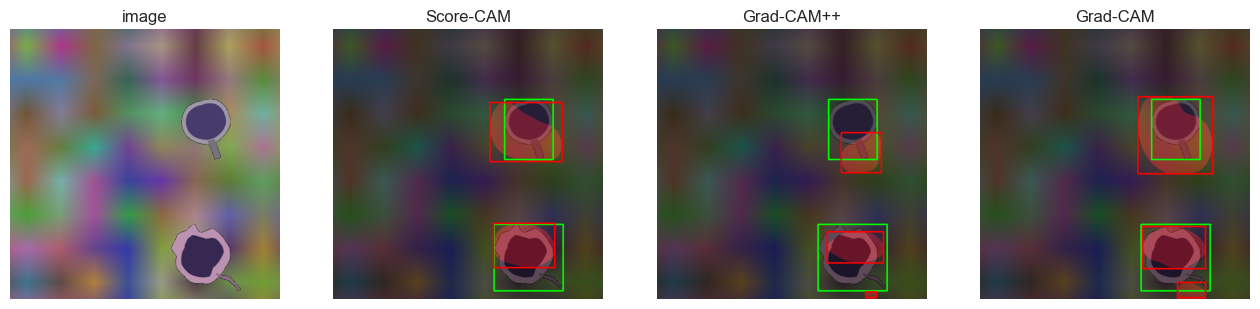

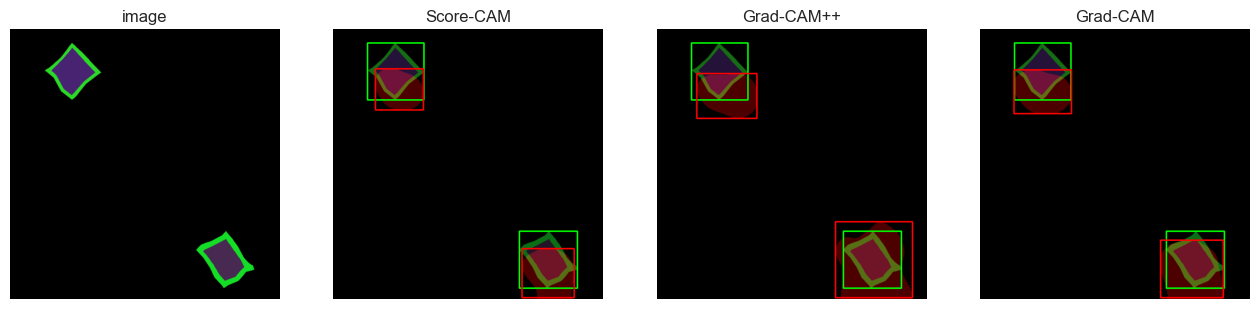

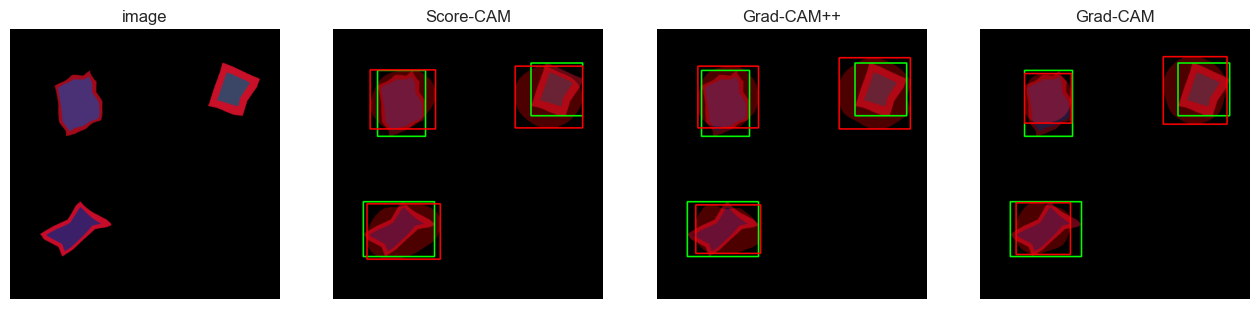

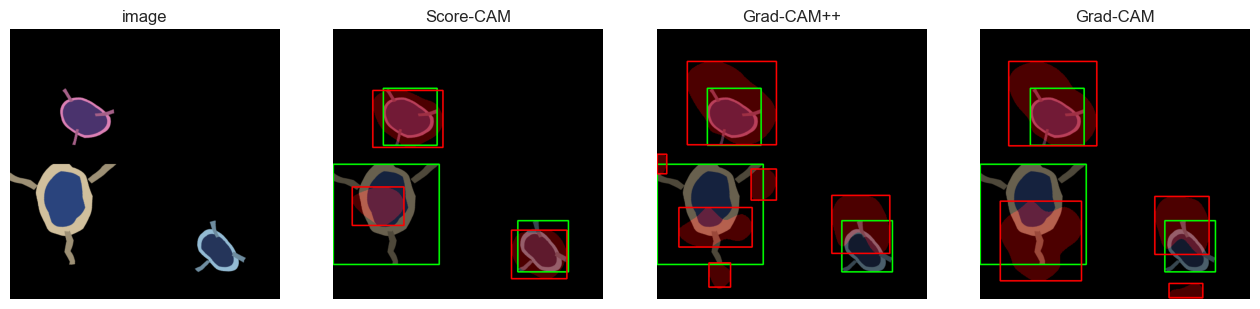

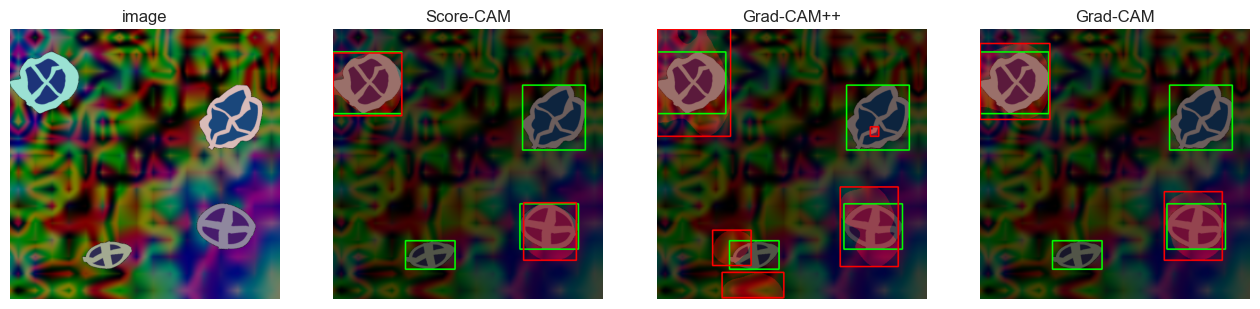

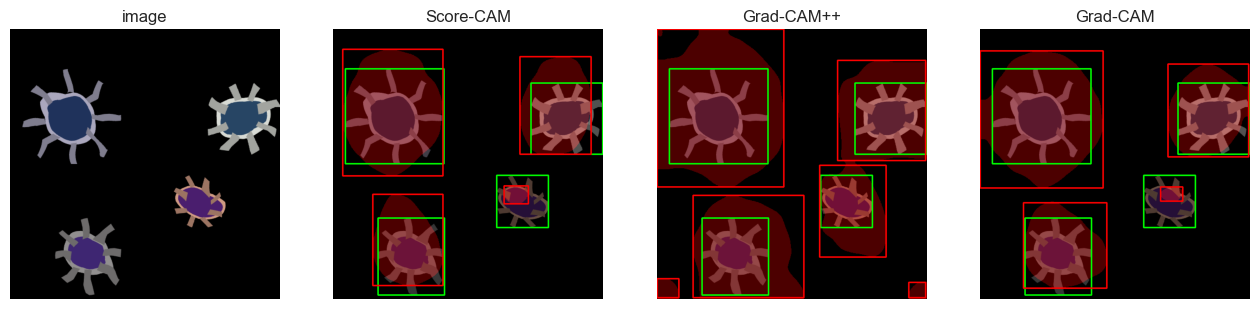

In [35]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

split = 'test'
image_id = 16

metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

for spec in sorted(df['tags.dataset_spec'].unique()):
    df_spec = df.loc[df['tags.dataset_spec'] == spec]
    df_spec = df_spec.loc[:, ['tags.method', 'tags.dataset_spec', 'artifact_uri']]
    spec_dict = df_spec.set_index('tags.method').to_dict()
    uris = spec_dict['artifact_uri']
    spec = '_'.join(list(spec))
    filebase = f'SYNTHETIC_{spec}_test_{image_id}'
    file_img = filebase + '.png'
    file_ann = filebase + '_ann.png'
    path_img_orig = os.path.join(f'/Users/goemaereg/github.com/thesis/data/dataset/SYNTHETIC_v1/{spec}/{split}/SYNTHETIC_{spec}_{split}_{image_id}.png')
    _, axes = plt.subplots(1, 4, figsize=(16, 8))
    img = read_image(path=path_img_orig)
    axes[0].imshow(to_pil_image(img))
    axes[0].axis('off')
    axes[0].set_title('image')
    for i, (method, uri) in enumerate(uris.items()):
        path_img = os.path.join(uri, 'xai', split, file_ann)
        img = read_image(path=path_img)
        axes[i+1].imshow(to_pil_image(img))
        axes[i+1].axis('off')
        axes[i+1].set_title(labels_methods[method])
    plt.show()

## ResNet-50

In [84]:
metric = 'MaxBoxAccV3_recall'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_recall for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_recall_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 82.83 & 65.50 & 62.00 & 60.67 & 63.44 & 59.61 & 57.67 & 52.62 \\
Grad-CAM++ & 83.83 & 67.67 & 63.67 & 65.08 & 65.39 & 61.67 & 60.79 & 53.58 \\
MinMaxCAM & 75.33 & 60.67 & 57.58 & 48.92 & 52.00 & 53.72 & 54.33 & 49.92 \\
Score-CAM & 80.50 & 69.67 & 62.33 & 66.25 & 65.44 & 63.44 & 58.83 & 56.17 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_recall for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_recall_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & 82.83 & 65.50 & 62.00 & 60.

In [85]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_precision_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 74.27 & 52.56 & 64.18 & 64.47 & 68.11 & 63.30 & 63.84 & 58.63 \\
Grad-CAM++ & 75.63 & 55.49 & 64.77 & 68.09 & 69.15 & 64.90 & 65.79 & 58.81 \\
MinMaxCAM & 64.47 & 45.72 & 60.08 & 49.78 & 57.44 & 56.71 & 61.95 & 56.49 \\
Score-CAM & 73.90 & 58.39 & 62.94 & 68.44 & 68.17 & 65.84 & 63.99 & 61.00 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_precision_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & 74.27 & 5

In [86]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for ResNet-50 on synthetic}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 71.89 & 57.79 & 70.16 & 71.97 & 71.62 & 70.04 & 69.90 & 64.32 \\
Grad-CAM++ & 73.03 & 60.93 & 71.48 & 73.88 & 72.50 & 70.79 & 70.55 & 64.91 \\
MinMaxCAM & 60.47 & 48.43 & 63.95 & 55.16 & 61.16 & 61.90 & 65.72 & 59.95 \\
Score-CAM & 72.27 & 61.78 & 69.77 & 74.18 & 71.30 & 72.62 & 68.78 & 65.77 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for ResNet-50 on synthetic}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & 71.89 & 57.79 & 70.16 & 71.97 & 71.62 & 70.04 & 69.90 & 64.32 \\
Grad-CAM++ & \color{teal} \bfseries 73.03 & 60

## ImageNet - VGG16-GAP

In [55]:
metrics = None
metric_name = 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=metrics, caption=caption, label=label)

\begin{table}[ht]
\caption{Metrics for VGG16-GAP on ImageNet}
\label{tb:metrics_vgg16_imagenet}
\begin{tabular}{lrrrr}
\toprule
method & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
\midrule
CAM & 61.19 & 60.22 & 36.73 & 38.44 \\
Grad-CAM++ & 61.29 & 60.43 & 36.87 & 38.66 \\
Score-CAM & 58.44 & 57.56 & 37.33 & 36.48 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{Metrics for VGG16-GAP on ImageNet}
\label{tb:metrics_vgg16_imagenet}
\begin{tabular}{lrrr}
 & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
method &  &  &  &  \\
CAM & 61.19 & 60.22 & \color{purple} \bfseries 36.73 & 38.44 \\
Grad-CAM++ & \color{teal} \bfseries 61.29 & \color{teal} \bfseries 60.43 & 36.87 & \color{teal} \bfseries 38.66 \\
Score-CAM & \color{purple} \bfseries 58.44 & \color{purple} \bfseries 57.56 & \color{teal} \bfseries 37.33 & \color{purple} \bfseries 36.48 \\
\end{tabular}
\end{table}



## ImageNet - ResNet-50

In [56]:
metrics = None
metric_name = 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=metrics, caption=caption, label=label)

\begin{table}[ht]
\caption{Metrics for ResNet-50 on ImageNet}
\label{tb:metrics_resnet50_imagenet}
\begin{tabular}{lrrrr}
\toprule
method & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
\midrule
CAM & 57.60 & 57.25 & 30.55 & 36.58 \\
Grad-CAM++ & 59.40 & 58.55 & 31.17 & 37.53 \\
MinMaxCAM & 58.81 & 57.26 & 43.70 & 36.02 \\
Score-CAM & 56.19 & 56.35 & 29.60 & 35.92 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{Metrics for ResNet-50 on ImageNet}
\label{tb:metrics_resnet50_imagenet}
\begin{tabular}{lrrr}
 & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
method &  &  &  &  \\
CAM & 57.60 & 57.25 & 30.55 & 36.58 \\
Grad-CAM++ & \color{teal} \bfseries 59.40 & \color{teal} \bfseries 58.55 & 31.17 & \color{teal} \bfseries 37.53 \\
MinMaxCAM & 58.81 & 57.26 & \color{teal} \bfseries 43.70 & 36.02 \\
Score-CAM & \color{purple} \bfseries 56.19 & \color{purple} \bfseries 56.35 & \color{purple} \bfseries 29.60 & \co

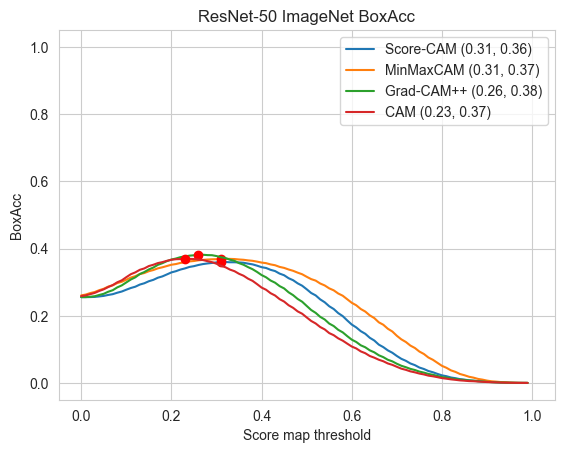

In [45]:
experiment_name = 'mwsol_resnet50_imagenet'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
boxacc, prcurve = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, conditions=conditions, split='val', box_metric='MaxBoxAccV3', mask_metric=None)
# BoxAcc
title = f"ResNet-50 ImageNet BoxAcc"
plot_boxacc(boxacc, title=title, iou_thresholds=[50])
if prcurve is not None:
    # PR Curve
    title = f"ResNet-50 ImageNet PR Curve"
    plot_prcurve(prcurve, title)

In [31]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'mwsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
conditions = {
    'tags.dataset': dataset, 'tags.dataset_spec': spec, 'tags.architecture_type': archtype, 'tags.method': 'minmaxcam'}
iou_boxacc, _ = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, conditions=conditions, split='test')

In [32]:
list(iou_boxacc)

['minmaxcam']

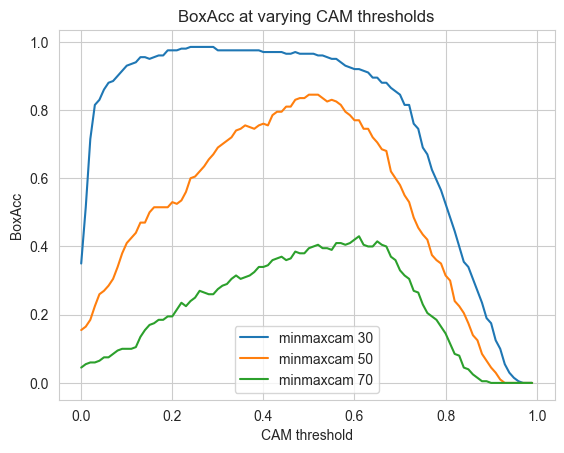

In [33]:
for method, iou_values in iou_boxacc.items():
    for iou_threshold, boxacc in iou_values.items():
        label = f'{method} {iou_threshold}'
        plt.plot(boxacc['cam_threshold'], boxacc['box_accuracy'], label = label)
plt.xlabel("CAM threshold")
plt.ylabel("BoxAcc")
plt.title('BoxAcc at varying CAM thresholds')
plt.legend()
plt.show()

### Training performance

In [34]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'wsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
# run_id = '63fa71e18f4849a19f49b2923adf57a3'
# run_id = 'e6f2d6ba4ca24e31ba7b57c2e2d0266b'
conditions = {'tags.mlflow.runName': run_name}
runs = mlflow_get_runs(experiment_name, conditions=conditions)

In [35]:
runs

run_id       experiment_id    status   
0  df000b8b56444239967892aecd5cc432  965153792060422881  FINISHED  \
1  6dcc4de27f924438aec2e5fa9c4cc642  965153792060422881  FINISHED   

                                        artifact_uri   
0  file:///users/goemaereg/github.com/thesis/mlru...  \
1  file:///users/goemaereg/github.com/thesis/mlru...   

                        start_time                         end_time   
0 2023-03-02 20:04:04.744000+00:00 2023-03-02 20:25:15.092000+00:00  \
1 2023-02-28 14:19:09.861000+00:00 2023-02-28 14:29:35.702000+00:00   

   metrics.test_PxAP  metrics.train_accuracy  metrics.val_MaxBoxAccV3_IOU_70   
0           0.610370                   0.994                           0.380  \
1           0.344443                   1.000                           0.115   

   metrics.test_runtime_cam  ...  tags.train_augment   
0               1108.864159  ...                True  \
1                987.823067  ...                True   

                       tags.mlflow.log-model.history  tags.model   
0  [{"run_id": "df000b8b56444239967892aecd5cc432"...   ResNetCam  \
1  [{"run_id": "6dcc4de27f924438aec2e5fa9c4cc642"...   ResNetCam   

   tags.optimizer  tags.dataset_spec  tags.method  tags.num_classes   
0             SGD                d1b    minmaxcam                 9  \
1             SGD                d1b    minmaxcam                 9   

                tags.mlflow.runName  tags.dataset  tags.architecture  
0  resnet50_minmaxcam_synthetic_d1b     SYNTHETIC           resnet50  
1  resnet50_minmaxcam_synthetic_d1b     SYNTHETIC           resnet50  

[2 rows x 63 columns]

### Classification versus localization accuracy

In [39]:
from mlflow import MlflowClient

run_id = runs['run_id'][0]
client = MlflowClient()
val_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'val_accuracy')]
steps = list(range(len(val_accuracy)))
val_maxboxaccv3 = [metric.value for metric in client.get_metric_history(run_id, 'val_MaxBoxAccV3')]
val_pxap = [metric.value for metric in client.get_metric_history(run_id, 'val_PxAP')]

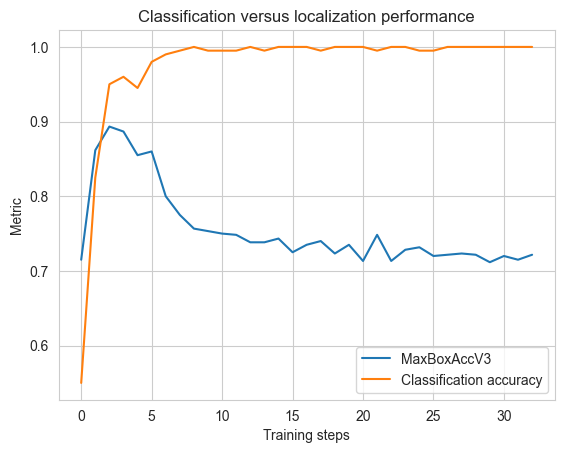

In [40]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

In [135]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'wsol_resnet50_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.loc[(df['method']=='cam') | (df['method']=='minmaxcam')&(df['start_time']>'2023-03-01')]
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

In [125]:
df

method dataset  epochs       metric    values
0    minmaxcam     d4b       0     accuracy     0.745
1    minmaxcam     d4b       0  MaxBoxAccV3    0.3675
2    minmaxcam     d4b       1     accuracy      0.87
3    minmaxcam     d4b       1  MaxBoxAccV3  0.477083
4    minmaxcam     d4b       2     accuracy      0.99
..         ...     ...     ...          ...       ...
941        cam     d1t      13  MaxBoxAccV3     0.735
942        cam     d1t      14     accuracy     0.995
943        cam     d1t      14  MaxBoxAccV3      0.73
944        cam     d1t      15     accuracy     0.995
945        cam     d1t      15  MaxBoxAccV3  0.728333

[946 rows x 5 columns]

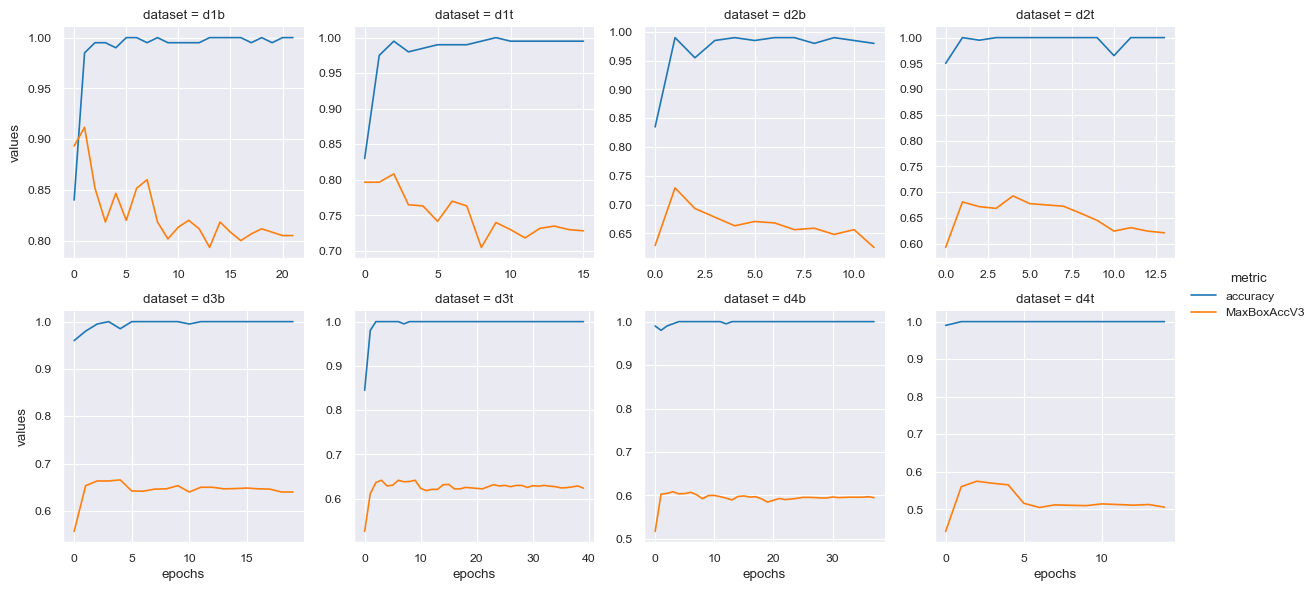

In [136]:
data = df.loc[df['method'] == 'cam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

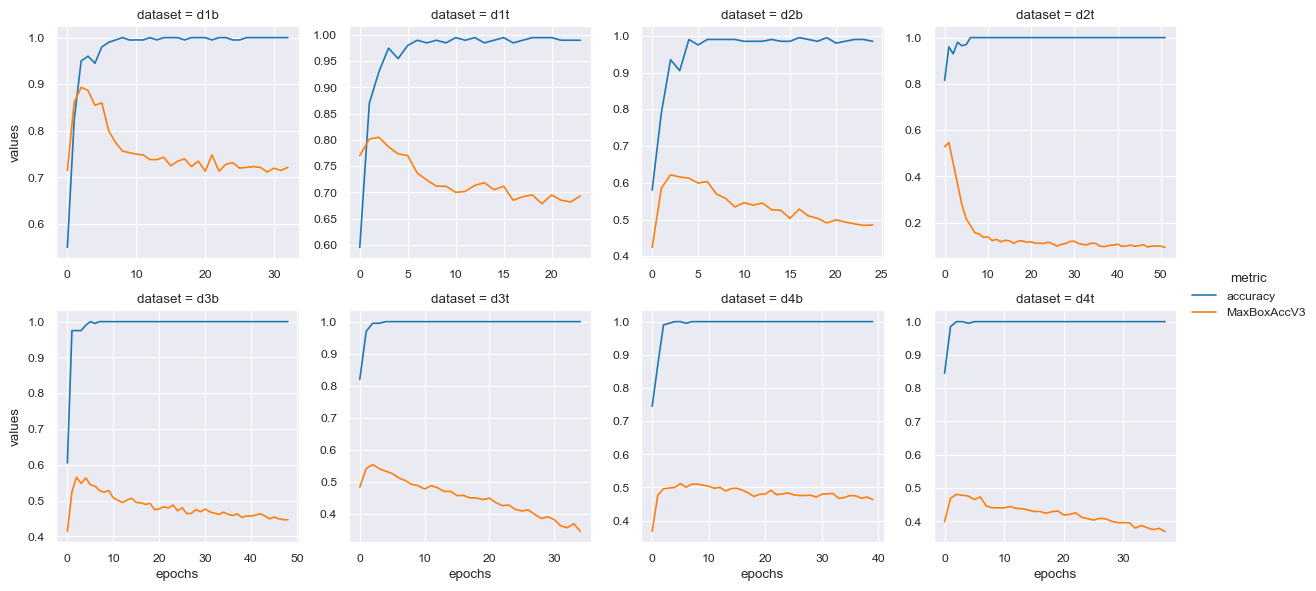

In [137]:
data = df.loc[df['method'] == 'minmaxcam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [138]:
dataset = 'SYNTHETIC'
archtype = 'cam'
experiment_name = 'wsol_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

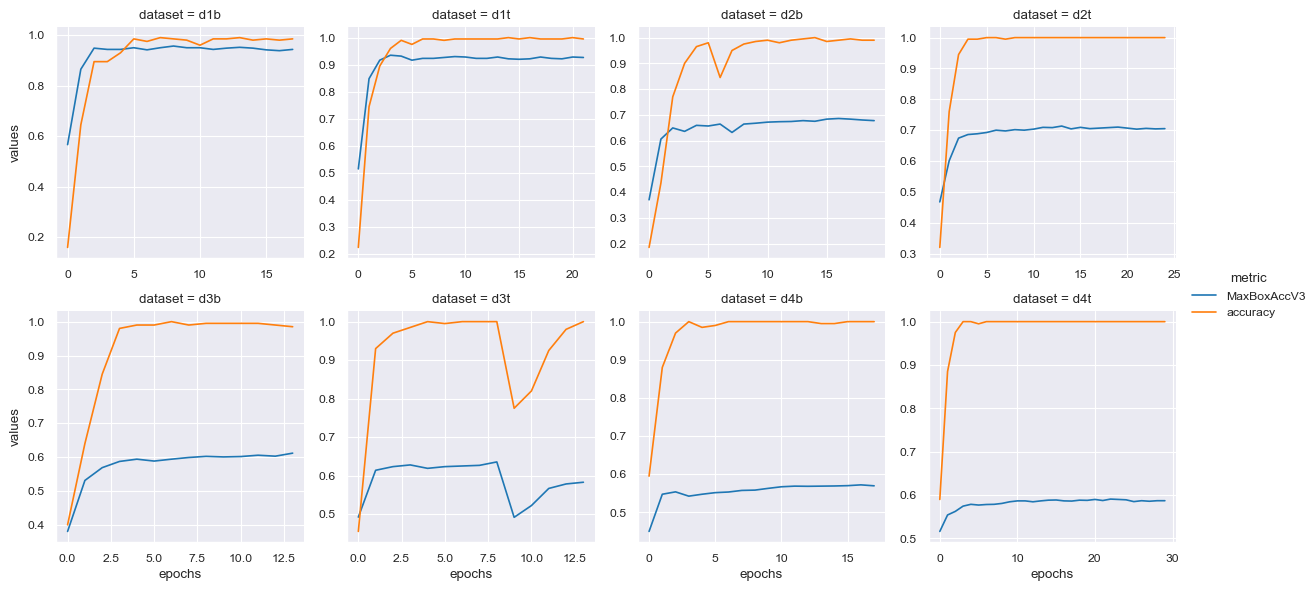

In [139]:
data = df.loc[df['method'] == 'cam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

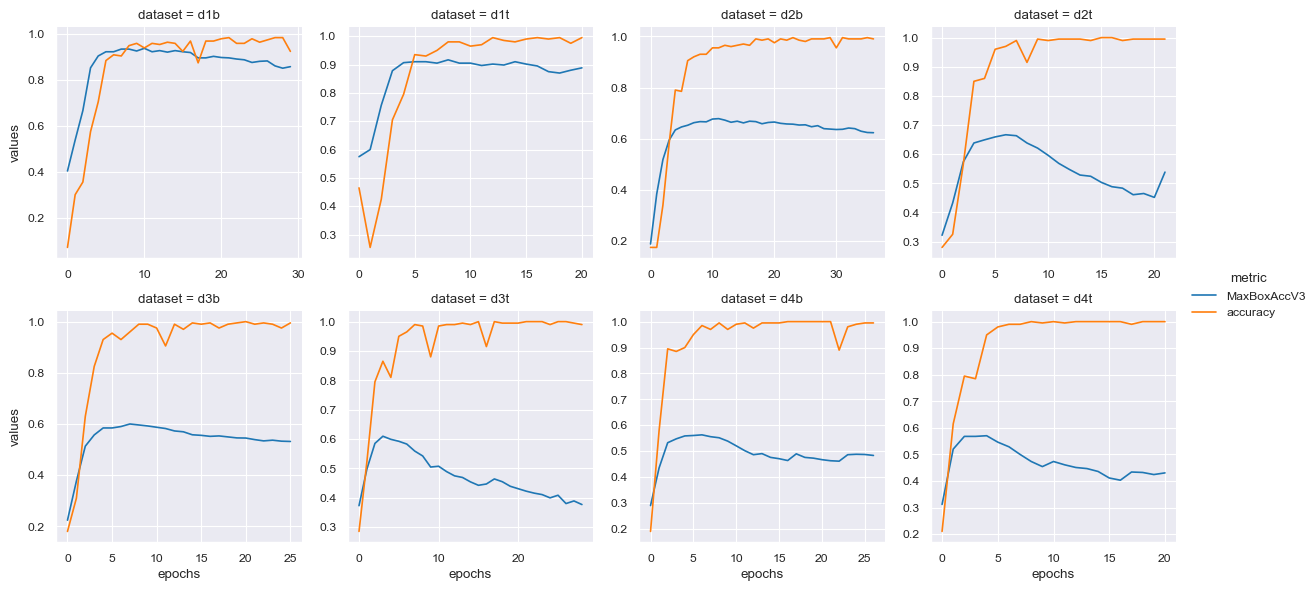

In [141]:
data = df.loc[df['method'] == 'minmaxcam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [143]:
dataset = 'SYNTHETIC'
archtype = 'vanilla'
experiment_name = 'wsol_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']
data = df.loc[df['method'] == 'gradcam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()x

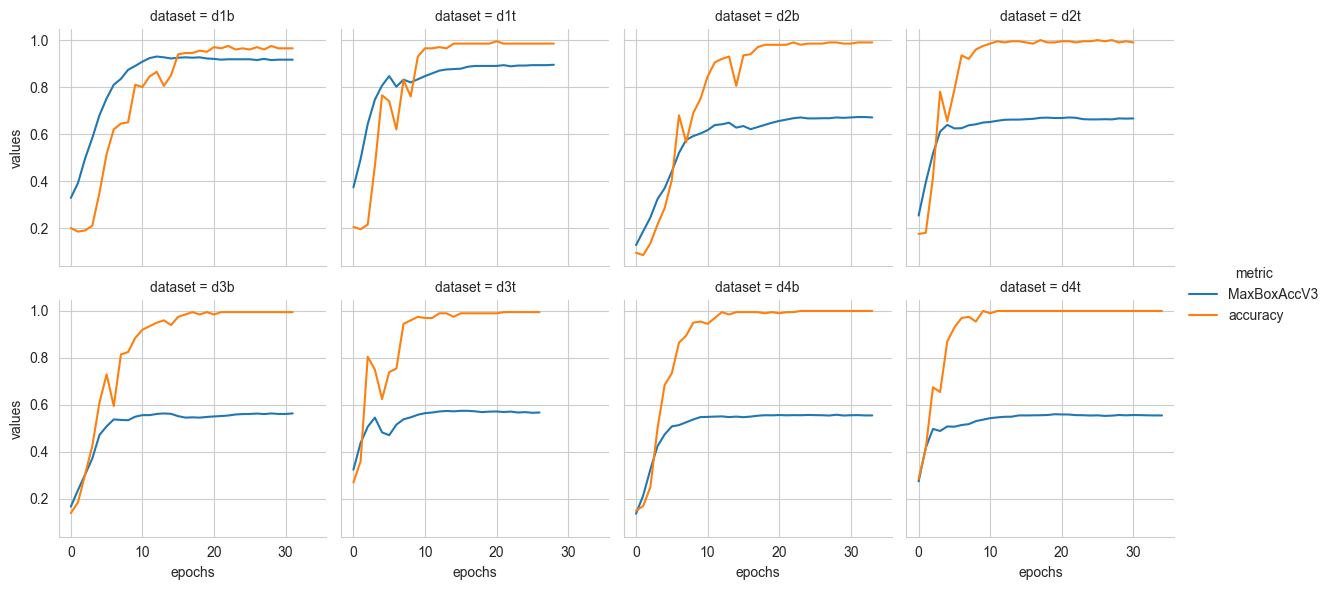

In [43]:
dataset = 'SYNTHETIC'
archtype = 'cam'
experiment_name = 'mwsol2_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.method': 'cam',
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.loc[(df['method']=='cam') | (df['method']=='minmaxcam')&(df['start_time']>'2023-03-01')]
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

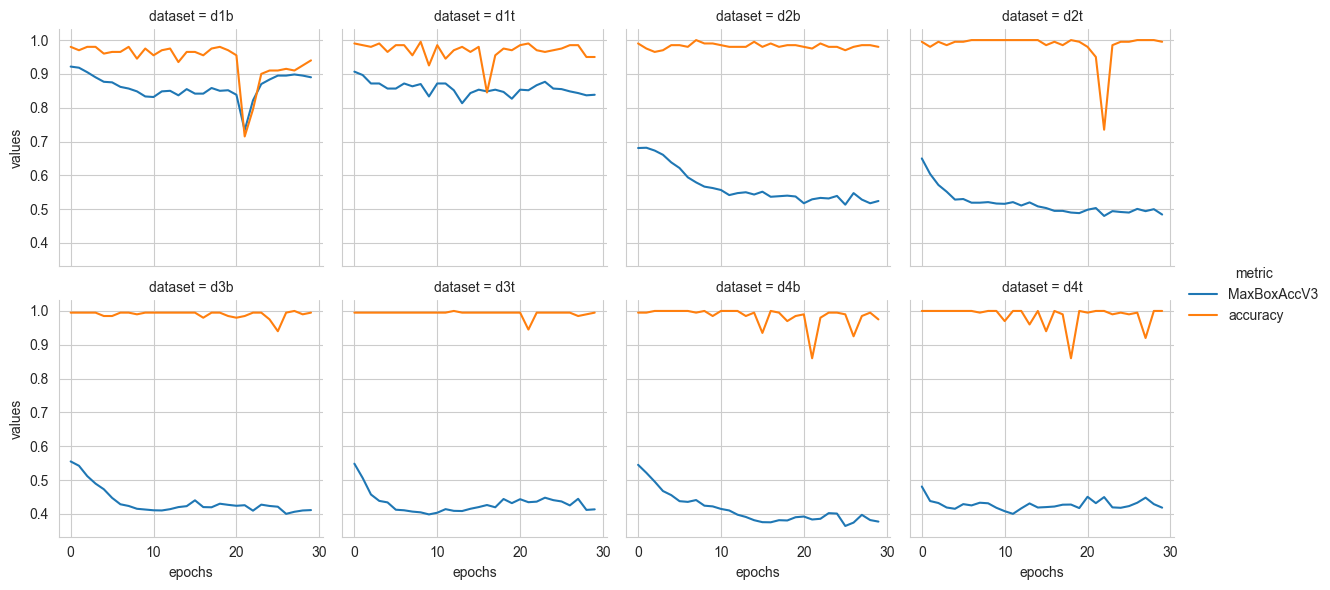

In [44]:
dataset = 'SYNTHETIC'
archtype = 'cam'
experiment_name = 'mwsol2_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.method': 'minmaxcam',
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.loc[(df['method']=='cam') | (df['method']=='minmaxcam')&(df['start_time']>'2023-03-01')]
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

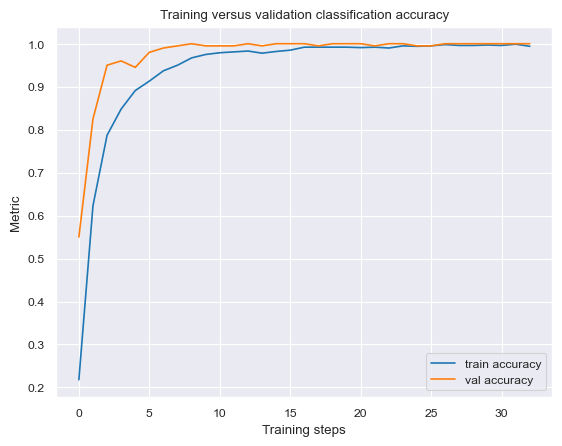

In [120]:
train_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'train_accuracy')]
plt.plot(steps, train_accuracy, label='train accuracy')
plt.plot(steps, val_accuracy, label='val accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Training versus validation classification accuracy')
plt.legend()
plt.show()

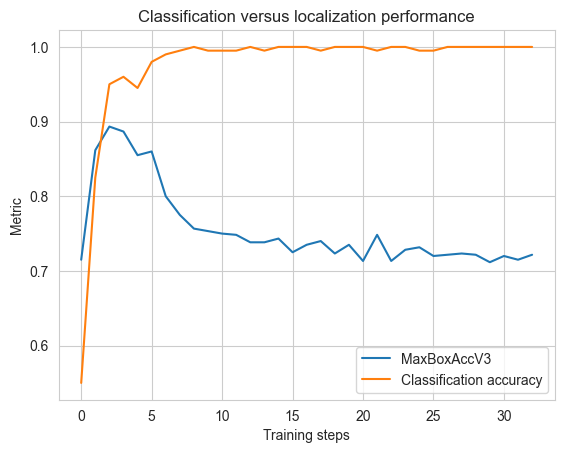

In [26]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

### Iterative localization

In [31]:
experiment_name = 'mwsol_vgg16_synthetic_iter'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.dataset_spec': 'd4b',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'tags.method': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df_runs = mlflow_get_runs(experiment_name, conditions)

In [32]:
import itertools
import numpy as np

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative CAM localization metrics for VGG16-GAP on synthetic dataset'
metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
metrics_short = ['recall','precision','f1']
split = 'test'

df = df_runs
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in metrics]
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_mlflow = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec']
cols_mlflow += cols_metrics_mlflow + cols_params_mlflow
cols_renamed = [c.split('.')[-1] for c in cols_mlflow]
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
df = df.rename(columns=mapper)
mapper = dict(zip(metrics, metrics_short))
df = df.rename(columns=mapper)
cols_params_short = ['mask', 'merge', 'stop']
mapper = dict(zip(cols_params, cols_params_short))
df = df.rename(columns=mapper)
# df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
# pd.set_option("display.precision", 2)
metrics = metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage
cols_filter = cols_params_short + metrics
df = df.loc[:, cols_filter]
cols_pivot = ['merge']
cols_index = ['stop', 'mask']
pivot_values = [np.sort(df.loc[:, c].unique()).tolist() for c in cols_pivot]
df = df.pivot(index=cols_index, columns=cols_pivot, values=metrics)
iterables = [metrics]
cols_format = dict([(col_index, '{:.2f}') for col_index in itertools.product(metrics, *pivot_values)])
s = df.style
s = s.format(cols_format)
s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')
latex_table = s.to_latex(
        # column_format="llll" + "r"*len(metrics),
        position="ht", position_float="centering",
        hrules=False, label=label, caption=caption,
        multirow_align="t", multicol_align="c")
print(latex_table)

\begin{table}[ht]
\centering
\caption{Iterative CAM localization metrics for VGG16-GAP on synthetic dataset}
\label{tab:iter_metrics_vgg16_cam_synthetic}
\begin{tabular}{llrrrrrrrrr}
 &  & \multicolumn{3}{c}{recall} & \multicolumn{3}{c}{precision} & \multicolumn{3}{c}{f1} \\
 & merge & add & drop & unify & add & drop & unify & add & drop & unify \\
stop & mask &  &  &  &  &  &  &  &  &  \\
\multirow[t]{3}{*}{0.25} & mean & 54.29 & 52.13 & 52.21 & \color{teal} \bfseries 54.09 & 61.21 & 61.30 & 54.19 & 56.30 & 56.39 \\
 & random & 53.92 & 52.04 & 51.75 & 53.26 & 62.28 & 62.06 & 53.59 & 56.70 & 56.44 \\
 & zero & \color{purple} \bfseries 52.92 & \color{purple} \bfseries 51.00 & \color{purple} \bfseries 50.96 & 53.20 & \color{teal} \bfseries 62.50 & \color{teal} \bfseries 62.31 & 53.06 & 56.17 & 56.07 \\
\multirow[t]{3}{*}{0.5} & mean & 56.75 & 54.29 & 55.71 & 52.41 & 59.86 & 61.02 & \color{teal} \bfseries 54.49 & 56.94 & \color{teal} \bfseries 58.24 \\
 & random & 56.88 & 54.08 & 54.54 & 

In [33]:
import itertools
import numpy as np

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative CAM localization metrics for VGG16-GAP on synthetic dataset'
metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
metrics_short = ['recall','precision','f1']
split = 'test'

df = df_runs
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in metrics]
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_mlflow = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec']
cols_mlflow += cols_metrics_mlflow + cols_params_mlflow
cols_renamed = [c.split('.')[-1] for c in cols_mlflow]
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
df = df.rename(columns=mapper)
mapper = dict(zip(metrics, metrics_short))
df = df.rename(columns=mapper)
cols_params_short = ['mask', 'merge', 'stop']
mapper = dict(zip(cols_params, cols_params_short))
df = df.rename(columns=mapper)
# df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
# pd.set_option("display.precision", 2)
metrics = metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage
cols_filter = cols_params_short + metrics
df = df.loc[:, cols_filter]
cols_pivot = ['merge']
cols_index = ['stop', 'mask']
pivot_values = [np.sort(df.loc[:, c].unique()).tolist() for c in cols_pivot]
df = df.pivot(index=cols_index, columns=cols_pivot, values=metrics)
cols_format = dict([(col_index, '{:.2f}') for col_index in itertools.product(metrics, *pivot_values)])
s = df.style
s = s.format(cols_format)
s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')
latex_table = s.to_latex(
        # column_format="llll" + "r"*len(metrics),
        position="ht", position_float="centering",
        hrules=False, label=label, caption=caption,
        multirow_align="t", multicol_align="c")
print(latex_table)

\begin{table}[ht]
\centering
\caption{Iterative CAM localization metrics for VGG16-GAP on synthetic dataset}
\label{tab:iter_metrics_vgg16_cam_synthetic}
\begin{tabular}{llrrrrrrrrr}
 &  & \multicolumn{3}{c}{recall} & \multicolumn{3}{c}{precision} & \multicolumn{3}{c}{f1} \\
 & merge & add & drop & unify & add & drop & unify & add & drop & unify \\
stop & mask &  &  &  &  &  &  &  &  &  \\
\multirow[t]{3}{*}{0.25} & mean & 54.29 & 52.13 & 52.21 & \color{teal} \bfseries 54.09 & 61.21 & 61.30 & 54.19 & 56.30 & 56.39 \\
 & random & 53.92 & 52.04 & 51.75 & 53.26 & 62.28 & 62.06 & 53.59 & 56.70 & 56.44 \\
 & zero & \color{purple} \bfseries 52.92 & \color{purple} \bfseries 51.00 & \color{purple} \bfseries 50.96 & 53.20 & \color{teal} \bfseries 62.50 & \color{teal} \bfseries 62.31 & 53.06 & 56.17 & 56.07 \\
\multirow[t]{3}{*}{0.5} & mean & 56.75 & 54.29 & 55.71 & 52.41 & 59.86 & 61.02 & \color{teal} \bfseries 54.49 & 56.94 & \color{teal} \bfseries 58.24 \\
 & random & 56.88 & 54.08 & 54.54 & 

In [34]:
experiment_name = 'mwsol_vgg16_synthetic_iter'
split = 'test'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {'tags.dataset_spec': 'd4b'}
# conditions |= {
#     'params.bbox_mask_strategy': 'mean',
#     'params.bbox_merge_strategy': 'unify',
#     'params.iter_stop_prob_delta': '0.5',
# }

df = mlflow_get_runs(experiment_name, conditions)

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative localization metrics for VGG16-GAP on synthetic dataset'
cols_metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in cols_metrics]
cols_metrics_short = ['recall','precision','f1']
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_params_short = ['mask', 'merge', 'stop']
cols_tags_mlflow = ['tags.method', 'tags.dataset_spec']
cols_tags_short = ['method', 'dataset']

cols_mlflow = cols_tags_mlflow + cols_params_mlflow + cols_metrics_mlflow
cols_renamed = cols_tags_short + cols_params_short + cols_metrics_short
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)

metrics = cols_metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage

In [35]:
df

method dataset    mask  merge  stop     recall  precision         f1
0    scorecam     d4b  random  unify   1.0  67.916667  64.038821  65.920763
1    scorecam     d4b  random   drop   1.0  61.000000  58.852724  59.907127
2    scorecam     d4b  random    add   1.0  71.708333  36.335453  48.231460
3    scorecam     d4b    mean  unify   1.0  68.958333  62.918126  65.799903
4    scorecam     d4b    mean    add   1.0  70.333333  38.123636  49.445645
..        ...     ...     ...    ...   ...        ...        ...        ...
427       cam     d1b    zero    add  0.25  93.666667  71.048810  80.804856
428       cam     d1b    zero   drop  0.25  93.666667  86.838275  90.123314
429       cam     d1b    mean    add  0.25  94.166667  72.862355  82.155844
430       cam     d1b    mean   drop  0.25  94.166667  87.301587  90.604271
431       cam     d1b    mean  unify  0.25  90.333333  78.550725  84.031008

[432 rows x 8 columns]

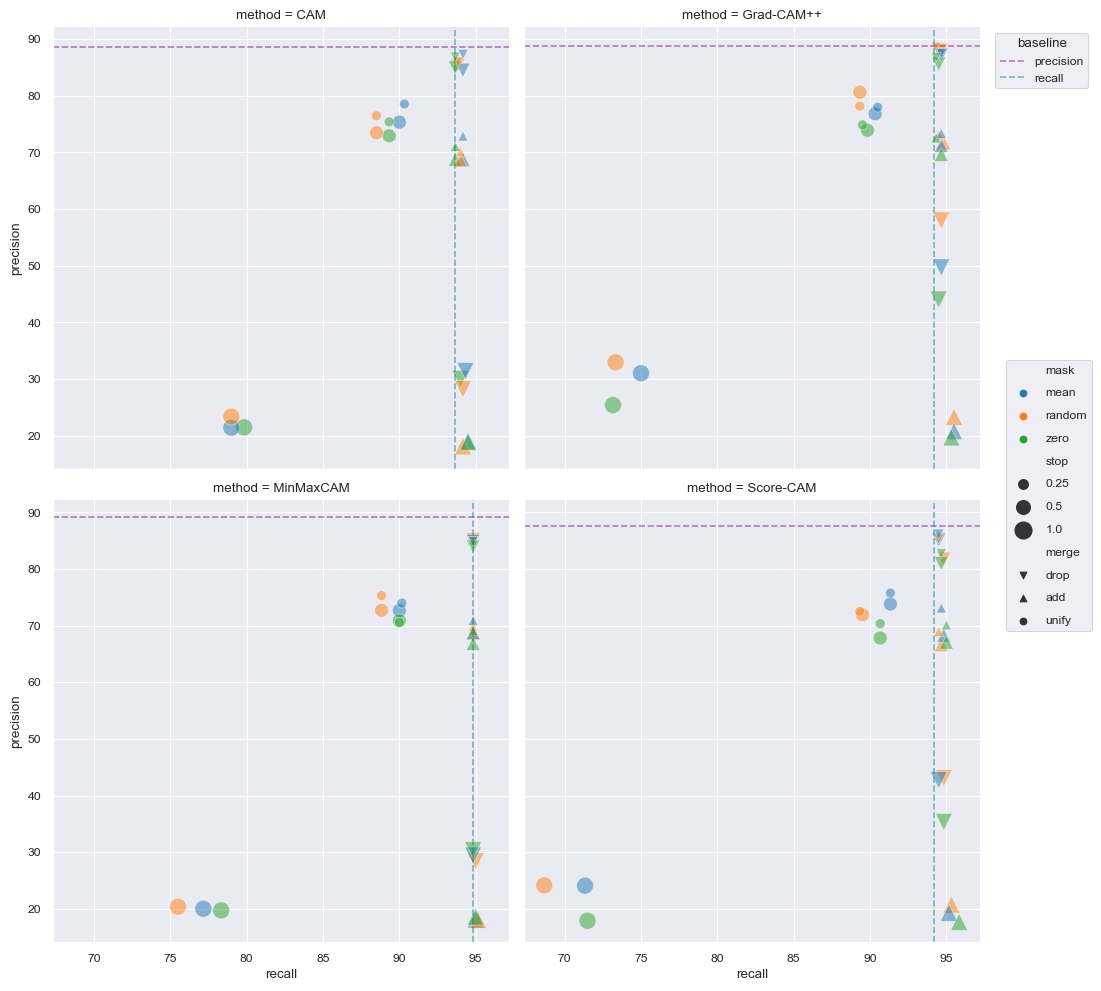

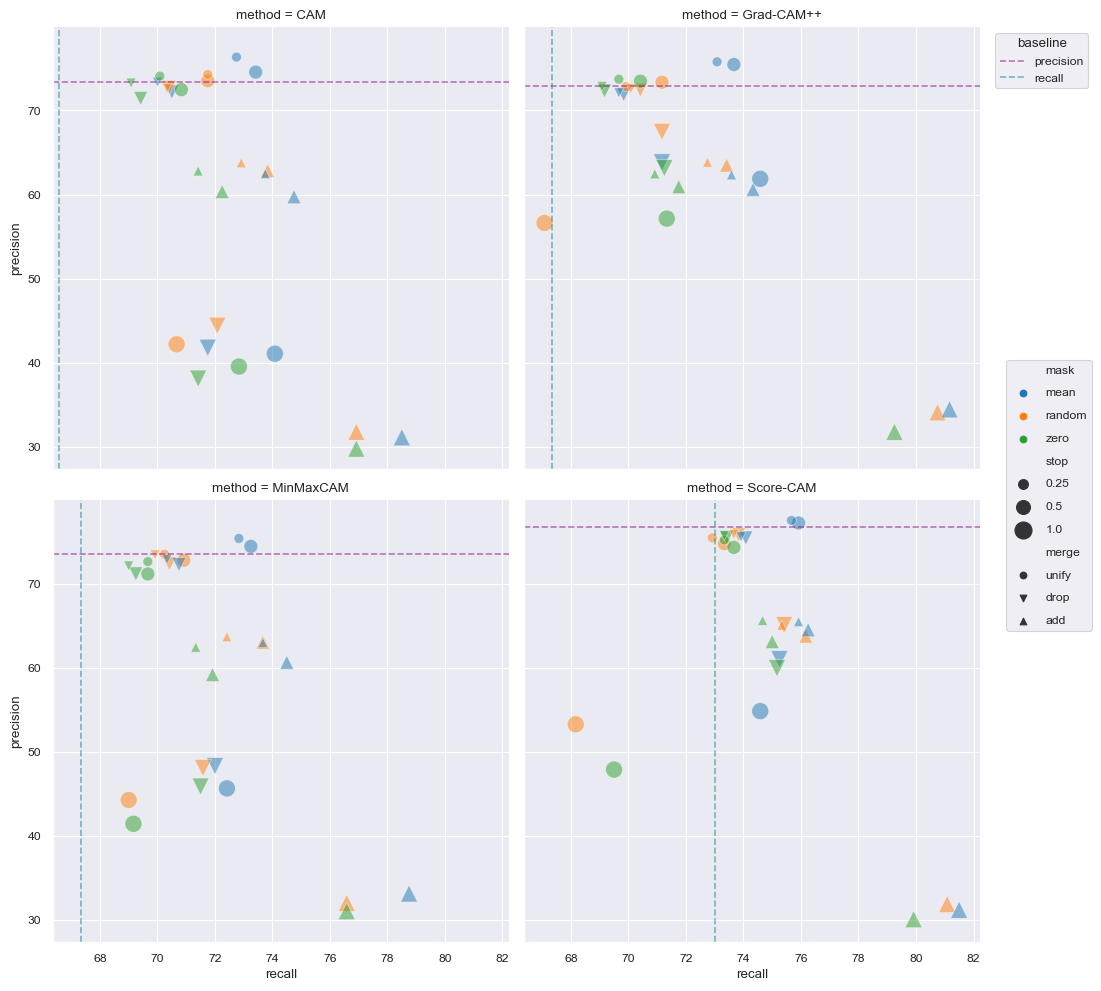

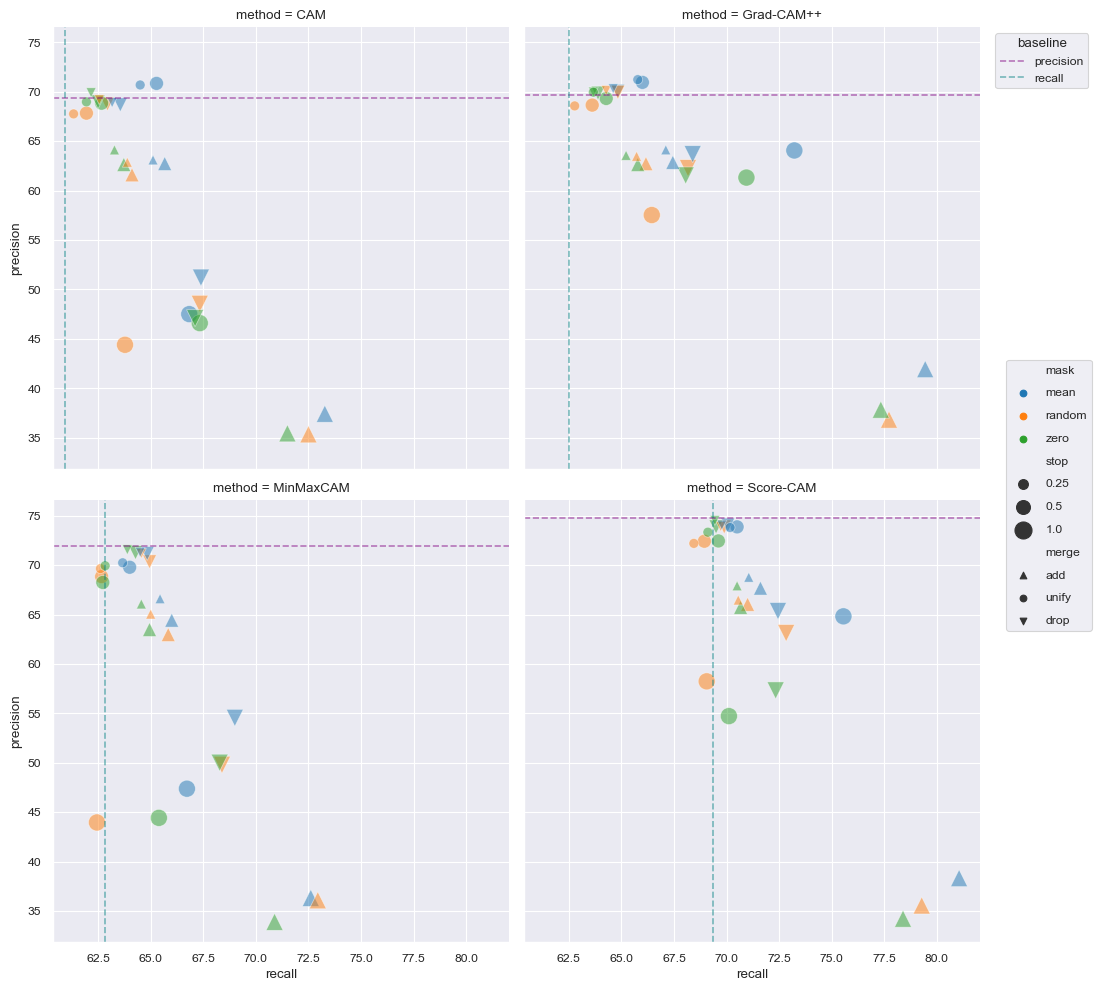

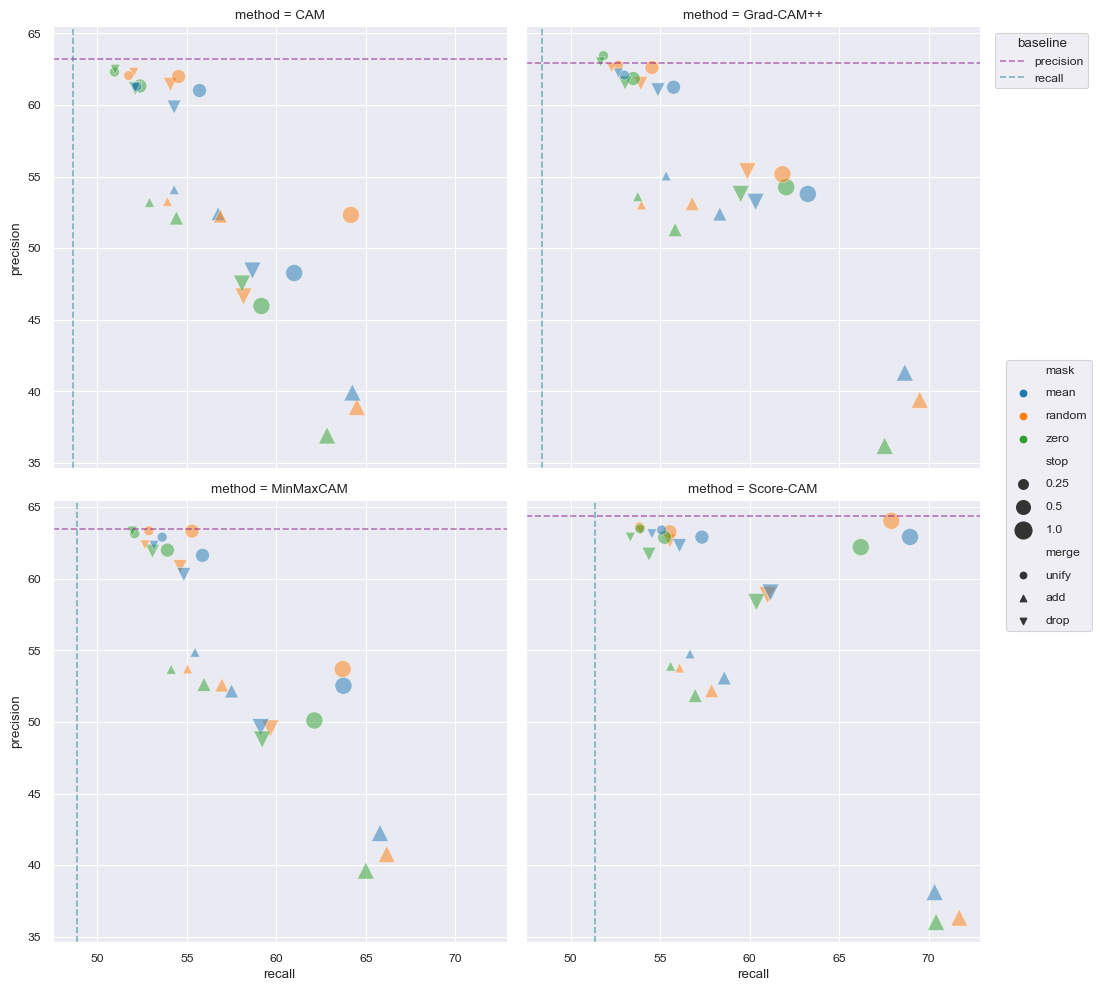

In [155]:
# baseline without iteration
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
split = 'test'
df_base = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method', 'tags.dataset_spec',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'spec', 'f1', 'precision', 'recall']
df_base = df_base.loc[:, cols]
df_base = df_base.rename(columns=dict(zip(cols, cols_renamed)))
prec_base = df_base.set_index(['spec', 'method']).to_dict()

# iterative experiments
experiment_name = 'mwsol_vgg16_synthetic_iter'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method', 'tags.dataset_spec',
        'params.bbox_mask_strategy', 'params.bbox_merge_strategy', 'params.iter_stop_prob_delta',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'spec',
                'mask', 'merge', 'stop',
                'f1', 'precision', 'recall']
mapper = dict(zip(cols, cols_renamed))
df = df.loc[:, cols].rename(columns=mapper)
df = df.replace({'method': labels_methods})
for metric in ['precision', 'recall', 'f1']:
    df[metric] *= 100 # to percentage
df = df.sort_values(['method', 'spec'])
for spec in [f'd{i}b' for i in range(1,5)]:
    df2 = df.loc[(df['spec'] == spec)]
    sns.set_style("darkgrid")
    sns.set_context("paper")
    markers = {'drop': 'v', 'add': '^', 'unify':'o'}
    sizes = {'0.25': 50, '0.5': 100, '1.0': 150}
    size_order = ['0.25', '0.5', '1.0']
    hue_order = ['mean','random','zero']
    sns_fig = sns.relplot(data=df2, x="recall", y="precision", hue="mask", style="merge",
                          size="stop", size_order=size_order, col='method', col_wrap=2,
                          markers=markers, sizes=sizes, hue_order=hue_order, alpha=0.5)
    sns.move_legend(sns_fig, loc='center right', bbox_to_anchor=(1.02, 0.5), labelspacing=1.0, frameon=True)

    # flatten axes into a 1-d array
    axes = sns_fig.axes.flatten()
    # iterate through the axes
    methods = ['cam', 'gradcam++', 'minmaxcam', 'scorecam']
    for i, ax in enumerate(axes):
        method = methods[i]
        precision = prec_base['precision'][(spec, method)] * 100
        recall = prec_base['recall'][(spec, method)] * 100
        line_prec = ax.axhline(precision, ls='--', c='purple', label='precision', alpha=0.5)
        line_rec = ax.axvline(recall, ls='--', c='teal', label='recall', alpha=0.5)
        if i == 1:
            lines = [line_prec, line_rec]
            labels = ['precision', 'recall']
            legend = ax.legend(lines, labels, bbox_to_anchor=(1.02, 1.0), loc='upper left', title='baseline', frameon=True)
    sns_fig.savefig(f'fig_iter_vgg16_gap_syn_{spec}.png')

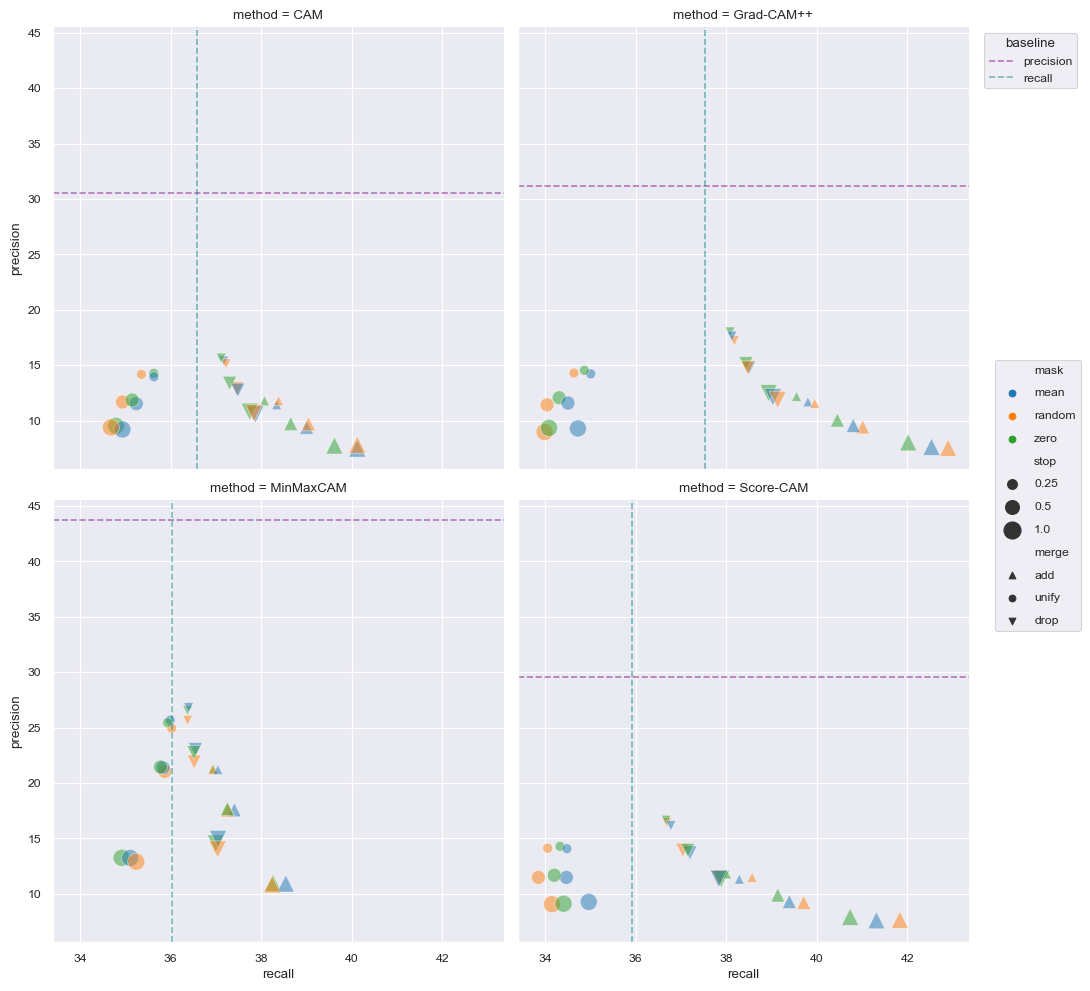

In [156]:
# baseline without iteration
experiment_name = 'mwsol_resnet50_imagenet'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
split = 'val'
df_base = mlflow_get_runs(experiment_name, conditions)
df_base = df_base.loc[df_base.start_time > '2023-05-01']
cols = ['tags.method',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'f1', 'precision', 'recall']
df_base = df_base.loc[:, cols]
df_base = df_base.rename(columns=dict(zip(cols, cols_renamed)))
prec_base = df_base.set_index(['method']).to_dict()

# iterative experiments
experiment_name = 'mwsol_resnet50_imagenet_iter'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method',
        'params.bbox_mask_strategy', 'params.bbox_merge_strategy', 'params.iter_stop_prob_delta',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method',
                'mask', 'merge', 'stop',
                'f1', 'precision', 'recall']
mapper = dict(zip(cols, cols_renamed))
df = df.loc[:, cols].rename(columns=mapper)
df = df.replace({'method': labels_methods})
for metric in ['precision', 'recall', 'f1']:
    df[metric] *= 100 # to percentage
df = df.sort_values(['method'])

sns.set_style("darkgrid")
sns.set_context("paper")
markers = {'drop': 'v', 'add': '^', 'unify':'o'}
# markers = {'drop': 'x', 'add': '+', 'unify':'2'}
sizes = {'0.25': 50, '0.5': 100, '1.0': 150}
size_order = ['0.25', '0.5', '1.0']
hue_order = ['mean','random','zero']
sns_fig = sns.relplot(data=df, x="recall", y="precision", hue="mask", style="merge",
                      size="stop", size_order=size_order, col='method', col_wrap=2,
                      markers=markers, sizes=sizes, hue_order=hue_order, alpha=0.5)
sns.move_legend(sns_fig, loc='center right', bbox_to_anchor=(1.02, 0.5), labelspacing=1.0, frameon=True)
# flatten axes into a 1-d array
axes = sns_fig.axes.flatten()
# iterate through the axes
methods = ['cam', 'gradcam++', 'minmaxcam', 'scorecam']
for i, ax in enumerate(axes):
    method = methods[i]
    precision = prec_base['precision'][method] * 100
    recall = prec_base['recall'][method] * 100
    line_prec = ax.axhline(precision, ls='--', c='purple', label='precision', alpha=0.5)
    line_rec = ax.axvline(recall, ls='--', c='teal', label='recall', alpha=0.5)
    if i == 1:
        lines = [line_prec, line_rec]
        labels = ['precision', 'recall']
        legend = ax.legend(lines, labels, bbox_to_anchor=(1.02, 1.0), loc='upper left', title='baseline', frameon=True)
sns_fig.savefig(f'fig_iter_resnet50_imagenet.png')

In [18]:
experiment_name = 'mwsol2_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
run_ids = df['run_id']
artifact_uris = df['artifact_uri']
run_names = df['tags.mlflow.runName']
run_id = run_ids
artifact_uri = artifact_uris
# run = mlflow.get_run(run_id)
for run_id, run_name, artifact_uri in zip(run_ids, run_names, artifact_uris):
    training_json = mlflow.artifacts.load_dict(artifact_uri[5:] + "/state/training.json")
    print(f'{run_name}: {training_json["epochs_trained"]}/{training_json["epochs_planned"]} epochs')


vgg16_gap_cam_synthetic_d2b: 34/100 epochs
vgg16_gap_cam_synthetic_d4b: 34/100 epochs
vgg16_gap_cam_synthetic_d4t: 35/100 epochs
vgg16_gap_cam_synthetic_d3t: 27/100 epochs
vgg16_gap_cam_synthetic_d3b: 32/100 epochs
vgg16_gap_cam_synthetic_d1t: 29/100 epochs
vgg16_gap_cam_synthetic_d2t: 31/100 epochs
vgg16_gap_cam_synthetic_d1b: 32/100 epochs


In [11]:
training_json

{'epochs_planned': 100, 'epochs_trained': 34, 'early_stop': 'true'}

In [12]:
df

run_id       experiment_id    status   
0  3b24f881837f4b0d8fcdaff529afc2f9  444388991408104879  FINISHED  \
1  82a71dea78cc464aa258bc39885a602d  444388991408104879  FINISHED   
2  04e95e8bda3b4cbc937f09950ea1f96d  444388991408104879  FINISHED   
3  2613baadf34c4713a212196cb3b45b47  444388991408104879  FINISHED   
4  f8ec2c98318649ed91d4d14ede8a6b45  444388991408104879  FINISHED   
5  e6eccac9088540d4ba3cf8cb033aee77  444388991408104879  FINISHED   
6  68c9ce77a5ba42dcb92421993411c929  444388991408104879  FINISHED   
7  f20fca7ae1c2476fabb239267be51d0b  444388991408104879  FINISHED   

                                        artifact_uri   
0  file:///Users/goemaereg/github.com/thesis/mlru...  \
1  file:///Users/goemaereg/github.com/thesis/mlru...   
2  file:///Users/goemaereg/github.com/thesis/mlru...   
3  file:///Users/goemaereg/github.com/thesis/mlru...   
4  file:///Users/goemaereg/github.com/thesis/mlru...   
5  file:///Users/goemaereg/github.com/thesis/mlru...   
6  file:///Users/goemaereg/github.com/thesis/mlru...   
7  file:///Users/goemaereg/github.com/thesis/mlru...   

                        start_time                         end_time   
0 2023-05-20 10:11:28.017000+00:00 2023-05-20 10:31:36.409000+00:00  \
1 2023-05-20 10:03:49.340000+00:00 2023-05-20 10:24:22.509000+00:00   
2 2023-05-20 09:52:01.143000+00:00 2023-05-20 10:10:32.425000+00:00   
3 2023-05-20 09:50:16.047000+00:00 2023-05-20 10:09:24.766000+00:00   
4 2023-05-20 09:49:51.785000+00:00 2023-05-20 10:01:13.453000+00:00   
5 2023-05-20 09:30:50.319000+00:00 2023-05-20 09:49:20.855000+00:00   
6 2023-05-20 09:30:40.353000+00:00 2023-05-20 09:48:07.901000+00:00   
7 2023-05-20 09:30:13.298000+00:00 2023-05-20 09:48:59.984000+00:00   

   metrics.val_MaxBoxAcc_recall  metrics.test_MaxBoxAccV3_precision_IOU_50   
0                         0.890                                   0.694190  \
1                         0.860                                   0.687870   
2                         0.935                                   0.716475   
3                         0.915                                   0.715888   
4                         0.715                                   0.639610   
5                         0.940                                   0.883721   
6                         0.930                                   0.810298   
7                         0.965                                   0.915493   

   metrics.val_MaxBoxAccV3_optimal_threshold_IOU_30   
0                                              0.43  \
1                                              0.51   
2                                              0.54   
3                                              0.45   
4                                              0.46   
5                                              0.24   
6                                              0.49   
7                                              0.16   

   metrics.val_MaxBoxAccV2_f1  ...  tags.mlflow.project.entryPoint   
0                    0.411044  ...                            main  \
1                    0.406889  ...                            main   
2                    0.522857  ...                            main   
3                    0.530226  ...                            main   
4                    0.542358  ...                            main   
5                    0.865551  ...                            main   
6                    0.614415  ...                            main   
7                    0.889577  ...                            main   

   tags.optimizer  tags.method              tags.experiment  tags.model   
0             SGD          cam  vgg16_gap_cam_synthetic_d4b      VggCam  \
1             SGD          cam  vgg16_gap_cam_synthetic_d4t      VggCam   
2             SGD          cam  vgg16_gap_cam_synthetic_d3t      VggCam   
3             SGD          cam  vgg16_gap_cam_synthetic_d3b      VggCam   
4             SGD          cam  vgg16_gap_cam_synthetic_d